In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from load_and_clean import *
import numpy as np
import pandas as pd

from tslib.src import tsUtils
from tslib.tests import testdata

#warnings.filterwarnings(action='once')

%matplotlib inline
from filter_data import *
from syn_model import *

import warnings
warnings.filterwarnings("ignore")

from pyod.models.hbos import HBOS
from itertools import product

In [65]:

delta_variant_data = {'France': '2021-02-21',
                     'Ireland': '2021-02-26',
                     'Germany': '2021-03-01',
                     'Denmark': '2021-03-08',
                     'Belgium': '2021-03-25',
                     'Sweden': '2021-03-26',
                     'Switzerland': '2021-03-29',
                     'Italy': '2021-04-02',
                     'Portugal': '2021-04-05',
                     'Norway': '2021-04-06',
                     'United Kingdom': '2021-02-22',
                     'Finland': '2021-03-18',
                      'Korea, South': '2021-03-26',
                      'Japan': '2021-03-28',
                      'Netherlands': '2021-04-06',
                      'Luxembourg': '2021-04-15',
                      'Austria': '2021-04-17',
                      'Slovenia': '2021-04-20',
                      'Russia': '2021-04-21',
                      'US': '2021-02-23',
                      'Spain': '2021-04-22',
                      'Czechia': '2021-04-24',
                      'Poland': '2021-04-26',
                      'Turkey': '2021-04-28'
                     }


delta_variant_data = pd.DataFrame(delta_variant_data, index = ["Date"]).T
#delta_variant_data["Date"] = pd.to_datetime(delta_variant_data['Date'])
### Netherland
# target = "Netherlands"
# tick_spacing = 90

# donors = ["France", "Ireland", "Germany", "Denmark", "Belgium",
#          "Sweden", "Switzerland", "Italy", "Portugal", 
#          "Norway", "United Kingdom"]

# donor_start = ["2021-02-21", "2021-02-26", "2021-03-01", "2021-03-08", "2021-03-25", 
#                "2021-03-26", "2021-03-29", "2021-04-02", "2021-04-05", 
#                "2021-04-06", "2021-04-05", "2021-02-22"]

# target_start = "2021-04-06"

## Backward selection

In [4]:
def backward_donor_elimination(rscModel,metric=mean_squared_error, output = 'error_ratio', shuffle = False):
    '''
    Find the error ratio from removing each of the states within the donorpool

    @param
    metric: metric used to calculate ri values
    '''
    def syn_fit(shuffled_df,donorPool, hi_thresh,low_thresh):
        temp_model = syn_model(rscModel.state, rscModel.kSingularValues, [shuffled_df], hi_thresh, low_thresh, 
                            random_distribution = rscModel.random_distribution, lambdas = rscModel.lambdas, mRSC = rscModel.mRSC, otherStates=donorPool)
        temp_model.fit_model(force_positive=False)
        return temp_model
    
    def find_lo_high_thresh(donorPool, error_ratio = True):
        hi_thresh = rscModel.low_thresh if error_ratio else rscModel.thresh
        low_thresh = int(rscModel.low_thresh*.8) if error_ratio else rscModel.low_thresh
        shuffled_df = rscModel.dfs[0].iloc[:hi_thresh,:]
        if shuffle:
            shuffled_df = shuffled_df.iloc[np.random.permutation(len(shuffled_df))] 
        temp_model = syn_fit(shuffled_df,donorPool, hi_thresh,low_thresh)
        return temp_model.find_ri(metric) if error_ratio else temp_model.train_err

    out_dict = dict()
        
    for donor in rscModel.donors:
        donorPool = rscModel.donors.copy()
        donorPool.remove(donor)
        #only pre-intervention
        
        if output == 'error_ratio': 
            '''
            hi_thresh, low_thresh = rscModel.low_thresh, int(rscModel.low_thresh*.8)
            temp_model = syn_fit()
            out_dict[donor] = temp_model.find_ri(metric)
            '''
            out_dict[donor] = find_lo_high_thresh(donorPool, error_ratio = True)
            
        elif output == 'training_error':
            '''
            hi_thresh, low_thresh = rscModel.thresh, rscModel.low_thresh
            temp_model = syn_fit()
            out_dict[donor] = temp_model.train_err
            '''
            out_dict[donor] = find_lo_high_thresh(donorPool, error_ratio = False)
            
        #models[donor] = temp_model
        
        '''
        all_donors = np.array(list(out_dict.keys()))
        values = np.array(list(out_dict.values()))
        max_value = max(values)
        new_donors = all_donors[(values < max_value)]
        new_values = values[(values < max_value)]

        new_donors, new_values = all_donors, values
        '''
    
    new_donors = np.array(list(out_dict.keys()))
    values = np.array(list(out_dict.values()))
    max_value = max(values)
    print('donors:', len(new_donors),'removed:',new_donors[values == max_value ])
    new_donors,values = new_donors[(values < max_value)], values[(values < max_value)]
    
    return new_donors


## HBO

In [5]:
def permutation_train_test(rscModel, train_err = True, include_self = False):
    out_dict = dict()
    #models = dict()

    if include_self:
        if train_err:
            out_dict[rscModel.state] = rscModel.train_err
        else: 
            out_dict[rscModel.state] = rscModel.test_err 

    for donor in rscModel.donors:
        donorPool = rscModel.donors.copy()
        donorPool.remove(donor)
        temp_model = syn_model(donor, rscModel.kSingularValues, rscModel.dfs, rscModel.thresh, rscModel.low_thresh, 
                            random_distribution = rscModel.random_distribution, lambdas = rscModel.lambdas, mRSC = rscModel.mRSC, otherStates=donorPool)
        temp_model.fit_model(force_positive=False)
        if train_err:
            out_dict[donor] = temp_model.train_err
        else: 
            out_dict[donor] = temp_model.test_err 
        #models[donor] = temp_model


    return out_dict


def get_pre_filter(state, singVals, high_thresh, low_thresh):
    try:
        otherStates = df_pop.columns[(df_pop.iloc[low_thresh] < 
                                  df_pop[state].iloc[low_thresh]+.5*df_pop[state].iloc[low_thresh])&(df_pop.iloc[low_thresh]
                                  > df_pop[state].iloc[low_thresh]-0.5*df_pop[state].iloc[low_thresh])]
    except:
        return
    otherStates = list(otherStates[otherStates.isin(donors)])
    
    if state in otherStates:
        otherStates.remove(state)
    # Adding outliers:
    for item in outliers:
        otherStates.append(item)
        
        
    rscModel =syn_model(state, singVals, [df], high_thresh, low_thresh, otherStates=otherStates)
    try:
        rscModel.fit_model(filter_donor = False, singVals_estimate = True, singval_mathod ='auto')
    except Exception as e: 
        print(e)
        return
    
    return rscModel#.testing_error(), rscModel.training_error(), rscModel.donors, rscModel.kSingularValues
    

## Import data

In [6]:

#update_data()

#us = load_clean('NYTimes US')
uscases, usdeaths, usstates = load_clean('NYTimes states')
uscounties_cases, uscounties_deaths, uscounties = load_clean('NYTimes counties')
global_cases, global_deaths = load_clean('JHU global')
us_covid_jhu_cases, us_covid_jhu_deaths = load_clean('JHU US')
# mobility_data_apple = load_clean('mobility Apple')
# mobility_data_google, google_social = load_clean('mobility Google')
# sd_data = load_clean('IHME intervention')
all_population, us_population, usstates_population, uscounties_population = load_clean('population')

uscases_pop_adjusted, usdeaths_pop_adjusted = create_population_adjusted_data(uscases, all_population), \
                                    create_population_adjusted_data(usdeaths, all_population, show_exception = True)
global_cases_pop_adjusted, global_deaths_pop_adjusted = create_population_adjusted_data(global_cases, all_population), \
                                    create_population_adjusted_data(global_deaths, all_population, show_exception = True)

uscounties_cases_pop_adjusted = create_population_adjusted_data(uscounties_cases, all_population, show_exception = True, county = True)
uscounties_deaths_pop_adjusted = create_population_adjusted_data(uscounties_deaths, all_population, county = True)

# state_reopen = load_clean('state reopen')
# #fips_df = pd.read_csv("../COVID/COVID-19/csse_covid_19_data/UID_ISO_FIPS_LookUp_Table.csv")

# ctp_us_data = load_clean('CTP US')
# ctp_state_data = load_clean('CTP states')
# ctp_state_pop_adjusted = {stat: create_population_adjusted_data(data, all_population, show_exception=False) for stat, data in ctp_state_data.items()}

These countries/region do not have population data ['Virgin Islands']
These countries/region do not have population data ['Bahamas', 'Burma', 'Cabo Verde', 'Congo (Brazzaville)', 'Congo (Kinshasa)', "Cote d'Ivoire", 'Diamond Princess', 'Eswatini', 'Gambia', 'Holy See', 'Kyrgyzstan', 'MS Zaandam', 'Micronesia', 'North Macedonia', 'Saint Kitts and Nevis', 'Saint Lucia', 'Saint Vincent and the Grenadines', 'Slovakia', 'Summer Olympics 2020', 'Syria', 'Taiwan*', 'West Bank and Gaza']
These countries/region do not have population data ['Adjuntas-Puerto Rico', 'Aguada-Puerto Rico', 'Aguadilla-Puerto Rico', 'Aguas Buenas-Puerto Rico', 'Aibonito-Puerto Rico', 'Anasco-Puerto Rico', 'Anchorage-Alaska', 'Arecibo-Puerto Rico', 'Arroyo-Puerto Rico', 'Barceloneta-Puerto Rico', 'Barranquitas-Puerto Rico', 'Bayamon-Puerto Rico', 'Bristol Bay plus Lake and Peninsula-Alaska', 'Cabo Rojo-Puerto Rico', 'Caguas-Puerto Rico', 'Camuy-Puerto Rico', 'Canovanas-Puerto Rico', 'Carolina-Puerto Rico', 'Catano-Puer

In [7]:
#Filter data (this part might be overlapping some cells, but it should contain most of the varilables that are analyzed. )
# This part might be to split and explain
# This part might be to split and explain
t = 7
#column = list(mobility_data_google.columns).index('retail_and_recreation_percent_change_from_baseline')
global_deaths_filtered = create_filtered_data(global_deaths, 500 )
#the last column of social distancing dataset is the last social distancing measure used by a location
#educational_distancing = get_social_distancing(sd_data, sd_data.columns[-1])

all_data = pd.concat([global_deaths, usdeaths, uscounties_deaths], axis=1).dropna()
all_data_daily = create_rolling_data(all_data, t)

all_data_cases = pd.concat([global_cases, uscases, uscounties_cases], axis=1).dropna()
all_data_cases_daily = create_rolling_data(all_data_cases, t)

all_cases_data_pop = pd.concat([uscases_pop_adjusted,global_cases_pop_adjusted, uscounties_cases_pop_adjusted], axis = 1).dropna()
all_cases_data_pop_daily = create_rolling_data(all_cases_data_pop, t)

all_death_data_pop = pd.concat([usdeaths_pop_adjusted,global_deaths_pop_adjusted, uscounties_deaths_pop_adjusted], axis = 1).dropna()
all_death_data_pop_daily = create_rolling_data(all_death_data_pop, t)

# _, daily_global, intervention_date_global = create_intervention_adjusted_data(global_deaths, educational_distancing, t)
# _, daily_us, intervention_date_us = create_intervention_adjusted_data(usdeaths, educational_distancing, t)
# _, daily_uscounties, intervention_date_uscounties = create_intervention_adjusted_data(uscounties_deaths, educational_distancing, t)

# cases_intervention_adjusted, cases_intervention_adjusted_daily, intervention_date_case = create_intervention_adjusted_data(all_data_cases, educational_distancing, t)
# deaths_intervention_adjusted, deaths_intervention_adjusted_daily, intervention_date_death = create_intervention_adjusted_data(all_data, educational_distancing, t)
#deaths_intervention_adjusted_google, deaths_intervention_adjusted_daily_google, _ = create_intervention_adjusted_data(all_data, google_social, t)

# all_cases_data_pop_adjusted, all_cases_data_pop_adjusted_daily, _ = create_intervention_adjusted_data(all_cases_data_pop, educational_distancing, t)
# all_death_data_pop_adjusted, all_death_data_pop_adjusted_daily, _ = create_intervention_adjusted_data(all_death_data_pop, educational_distancing, t)

# hospitalized_pop_adjusted, hospitalized_pop_adjusted_daily, _ = create_intervention_adjusted_data(ctp_state_pop_adjusted['hospitalizedCurrently'], educational_distancing, t, ignore_nan=True)
# icu_pop_adjusted, icu_pop_adjusted_daily, _ = create_intervention_adjusted_data(ctp_state_pop_adjusted['inIcuCurrently'], educational_distancing, t, ignore_nan=True)
# ventilator_pop_adjusted, icu_pop_adjusted_daily, _ = create_intervention_adjusted_data(ctp_state_pop_adjusted['onVentilatorCurrently'], educational_distancing, t, ignore_nan=True)


## Mask Mandate for Delta

### Clean the the dataframe about government policy

In [124]:
gov_data = pd.read_excel("COVID_scores.xlsx")
gov_data['DATE'] = pd.to_datetime(gov_data['DATE'])
gov_data = gov_data[['STATE', "DATE", "CATEGORY5"]]
gov_data = gov_data.dropna()
gov_data["CATEGORY5"] = gov_data.dropna().groupby(by = ["STATE"]).cumsum()["CATEGORY5"]
min_date = np.min(gov_data.DATE)
max_date = np.max(gov_data.DATE)

date_df = pd.DataFrame(pd.date_range(start = min_date, end= max_date), columns = ["DATE"]).values.flatten()
state_df = pd.DataFrame(pd.unique(gov_data.STATE), columns = ["STATE"]).values.flatten()
temp_df = pd.DataFrame(list(product(state_df, date_df)), columns=['STATE', 'DATE'])

df = pd.merge(temp_df, gov_data, how = "outer")
mask_df = pd.pivot_table(df, values="CATEGORY5", index="DATE", columns="STATE", dropna = False)
mask_df.iloc[0] = 0
mask_df = mask_df.fillna(method="ffill")
mask_df.columns = mask_df.columns.map(lambda x: " ".join([w.capitalize() for w in x.split()]))
mask_df.rename(columns = {'District Of Columbia':'District of Columbia'}, inplace = True)

## State Level

- donors: states with mask mandate
- target: states that changes from mask mandate to no mask
- intervention date is the date that policy changes

In [144]:
start_date= "2021-02-23"
singVals = 3
data_df = all_cases_data_pop_daily.loc[start_date:]
data_df = data_df.iloc[:200]

date_range = 80

mask_mandate = list(mask_df.columns[np.all(mask_df.loc[start_date:].iloc[:date_range] > 0.5, axis = 0)])
non_mask_mandate = list(mask_df.columns[np.all(mask_df.loc[start_date:].iloc[:date_range] < 0.5, axis = 0)])
policy_change = list(set(mask_df.columns) - set(mask_mandate) - set(non_mask_mandate))

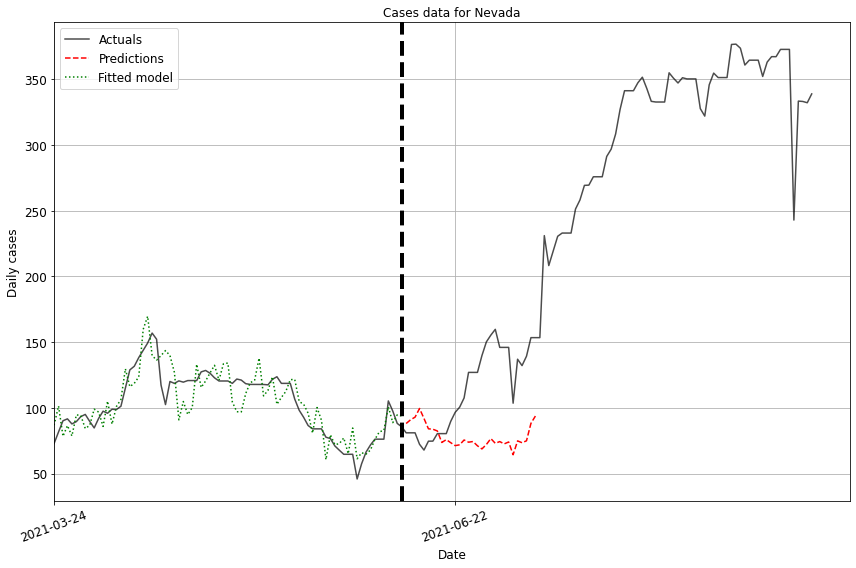

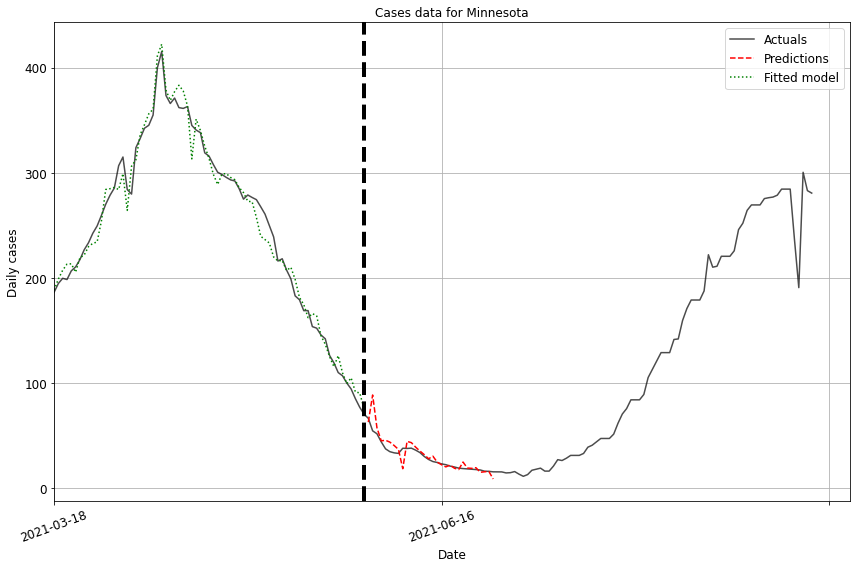

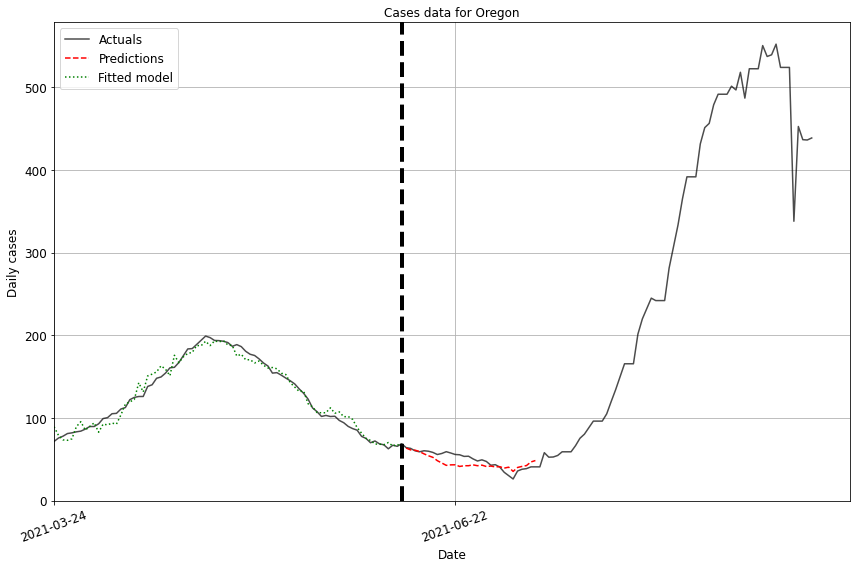

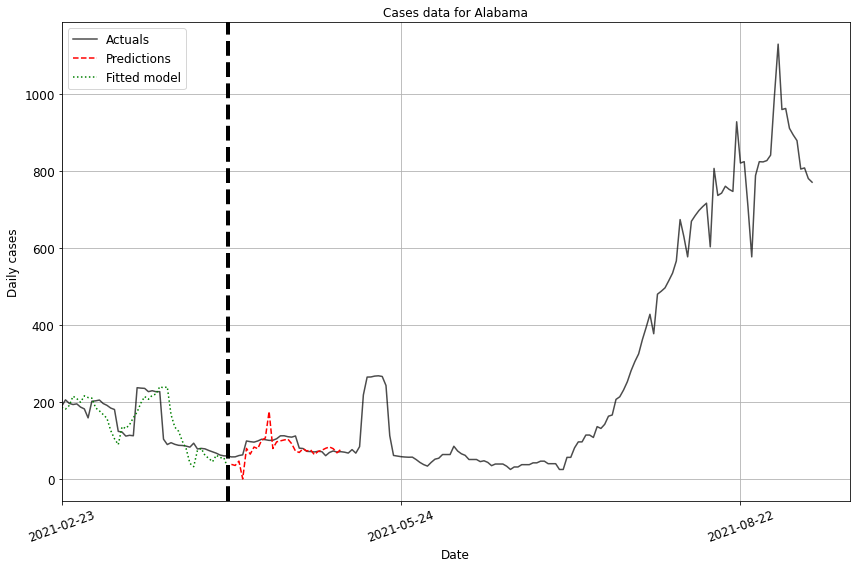

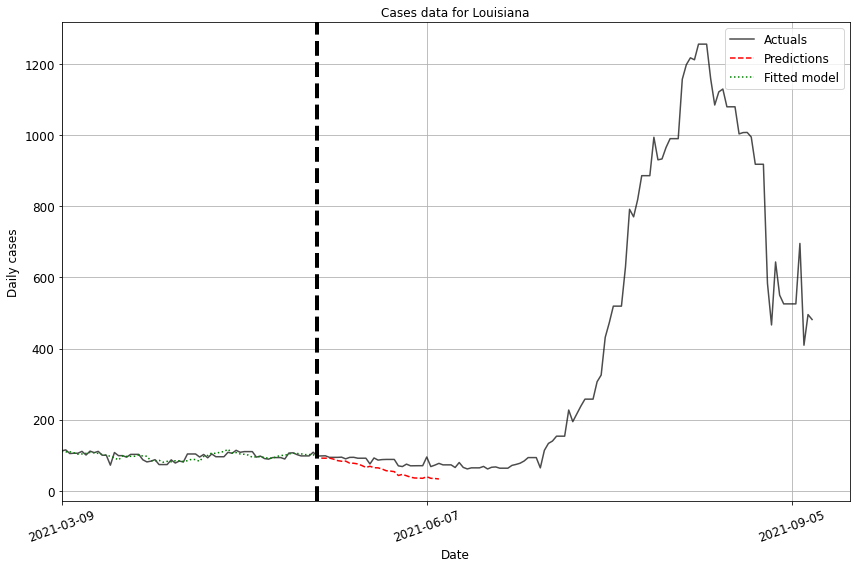

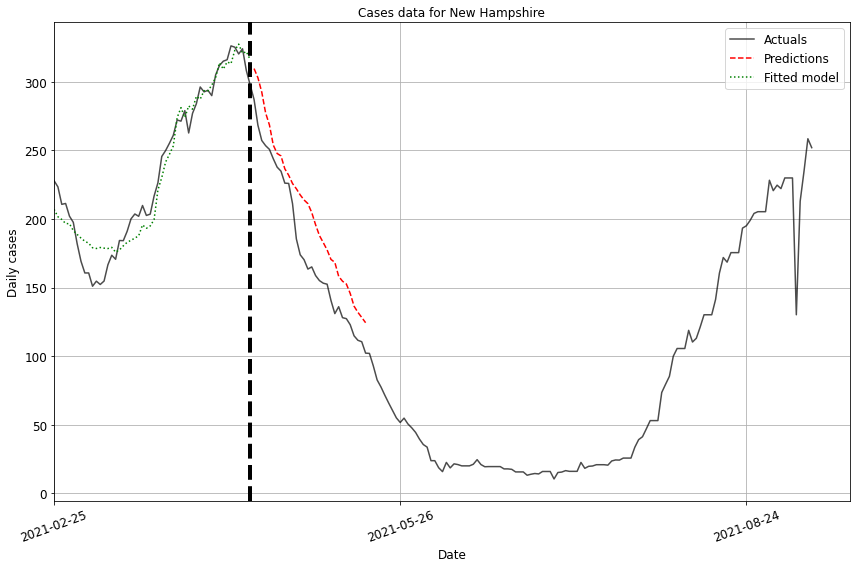

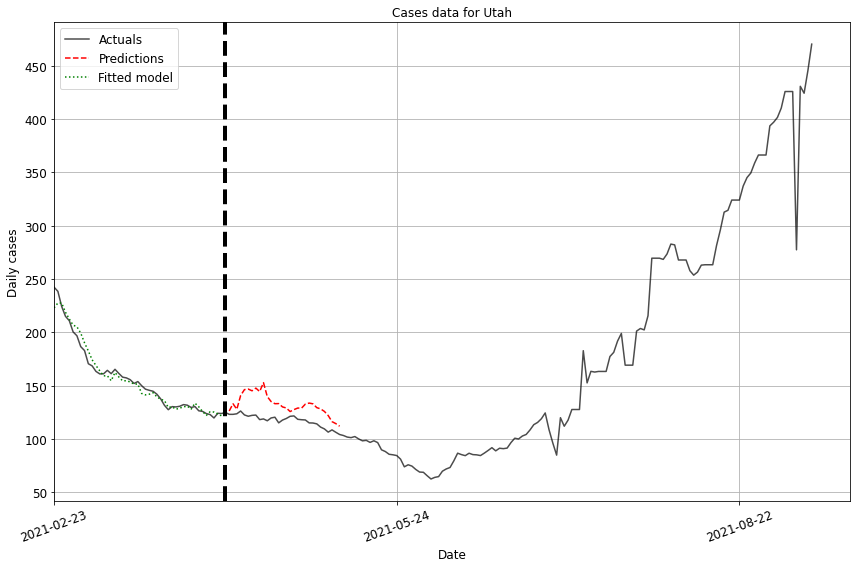

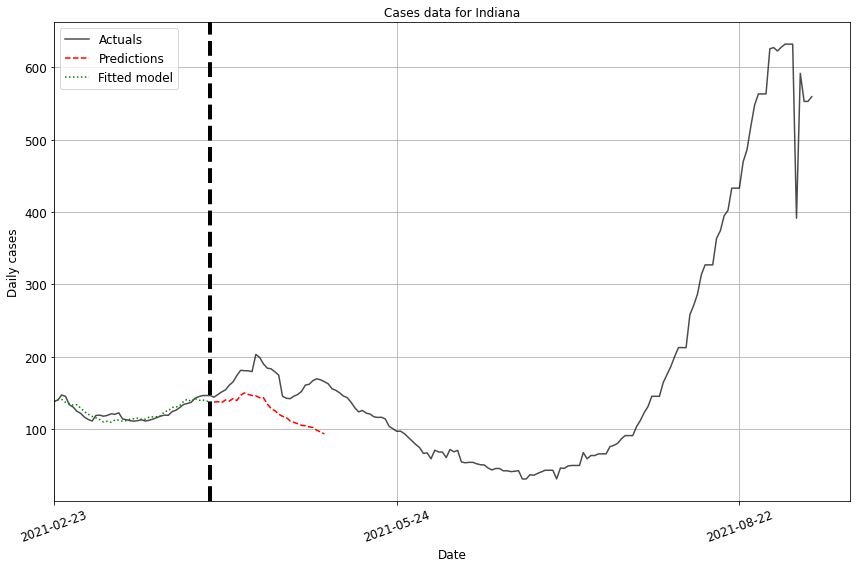

In [147]:
for state in policy_change:

    temp = mask_df[state].loc[start_date:].iloc[:date_range]
    intervention_date = np.arange(1, len(temp))[np.diff(temp) != 0][0]
    if intervention_date < 30:
        continue
    cur_data_df = data_df.iloc[np.maximum(0, intervention_date - 50):]
    
    rscModel =syn_model(state, singVals, [cur_data_df], intervention_date + 30, intervention_date, otherStates = mask_mandate)
    rscModel.fit_model(filter_donor = True, filter_method = 'hbo', singVals_estimate = True, singval_mathod ='auto')

    predictions = rscModel.predictions
    model_fit = rscModel.model_fit

    fig, axes = plt.subplots(1, 1, figsize = (12, 8))

    rscModel.plot(figure=fig, axes=axes, title_text="Cases data", ylimit=[], xlimit=[], logy=False, show_donors=False, tick_spacing=tick_spacing, xaxis="Date", yaxis="Daily cases", intervention_date_x_ticks=None, fontsize = 12)
    #plt.savefig("../Figures/COVID/"+county_state+".png",bbox_inches='tight')    
    plt.tight_layout()
    
                                  

## County Level

In [149]:
pop_scaled = create_population_adjusted_data(uscounties_cases, uscounties_population)

In [152]:


donors = []
for counties in uscounties_cases.columns:
    names = counties.split('-')
    if names[-1] in mask_mandate and names[0] != 'Unknown':
        donors.append(counties)
        
target_state = policy_change[-1]
print("Use the counties in state " + target_state)

targets = []
for counties in uscounties_cases.columns:
    names = counties.split('-')
    if names[-1] == target_state and names[0] != 'Unknown':
        targets.append(counties)
        
        
#targets = ['Los Angeles-California', 'Broward-Florida' ,'DeKalb-Georgia','Bartholomew-Indiana','Jefferson-Louisiana']#, 'Fulton-Georgia','Gwinnett-Georgia', 'Tarrant-Texas', 'Bexar-Texas','Collin-Texas','Mohave-Arizona','Yuma-Arizona','Maricopa-Arizona', 'Ascension-Louisiana',  'East Carroll-Louisiana']#counties_recommended# ['Ascension-Louisiana', 'Jefferson-Louisiana', 'Bartholomew-Indiana', 'Riverside-California', 'Broward-Florida' ]# #counties_recommended #masks_mandated


Use the counties in state Indiana


Counterfactual analysis of Mask recommended counties based on a donor pool of Mask mandated counties
175
174
Allen-Indiana 136.91011664981906


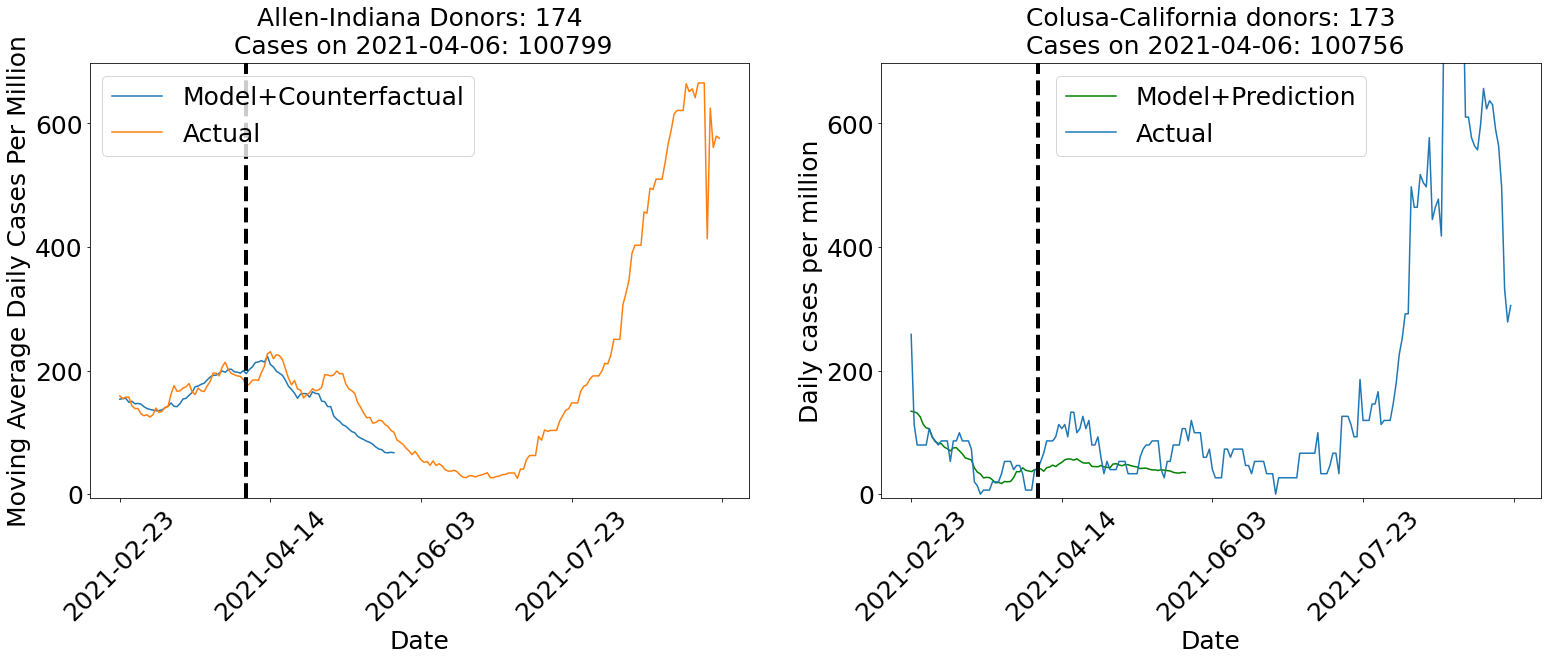

187
149
116
169
76
Brown-Indiana 336.8298693660562


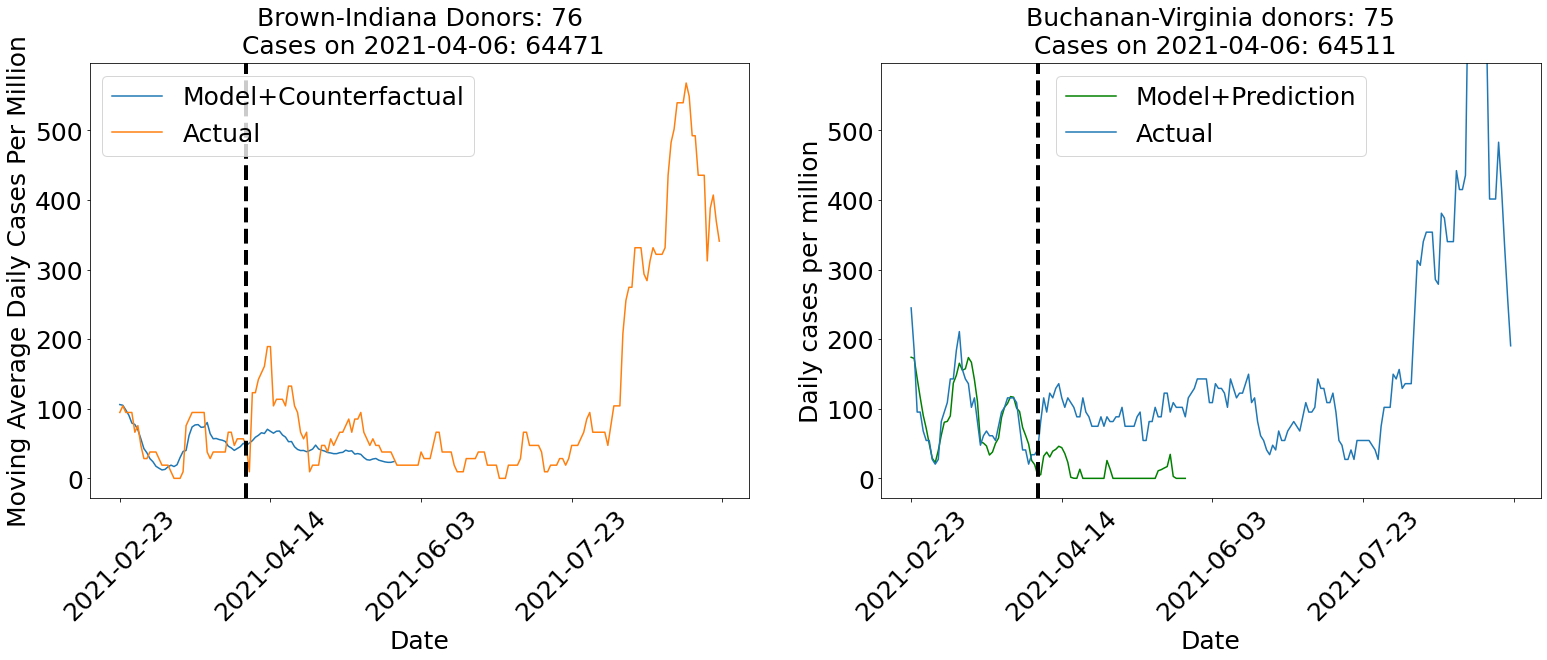

183
18
Cass-Indiana 1890.988206856608


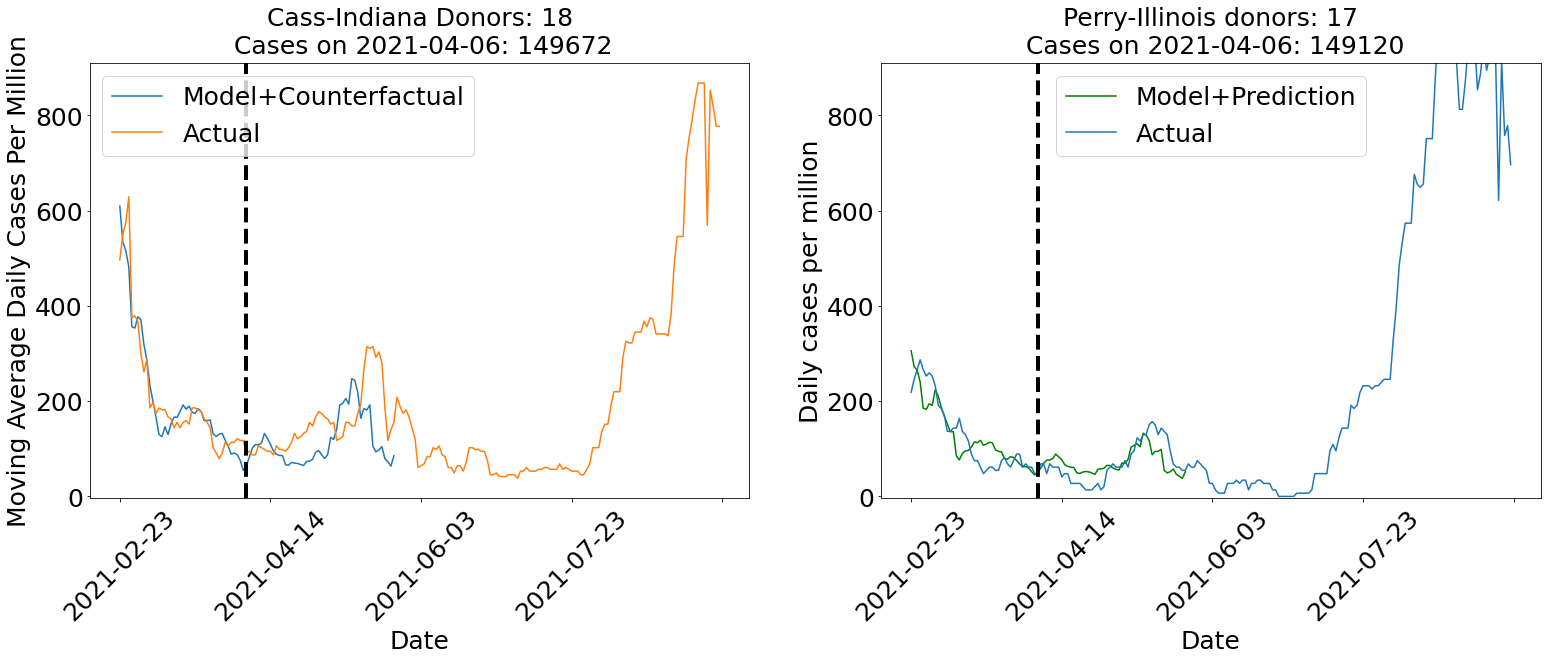

148
170
55
Clinton-Indiana 463.16245077110227


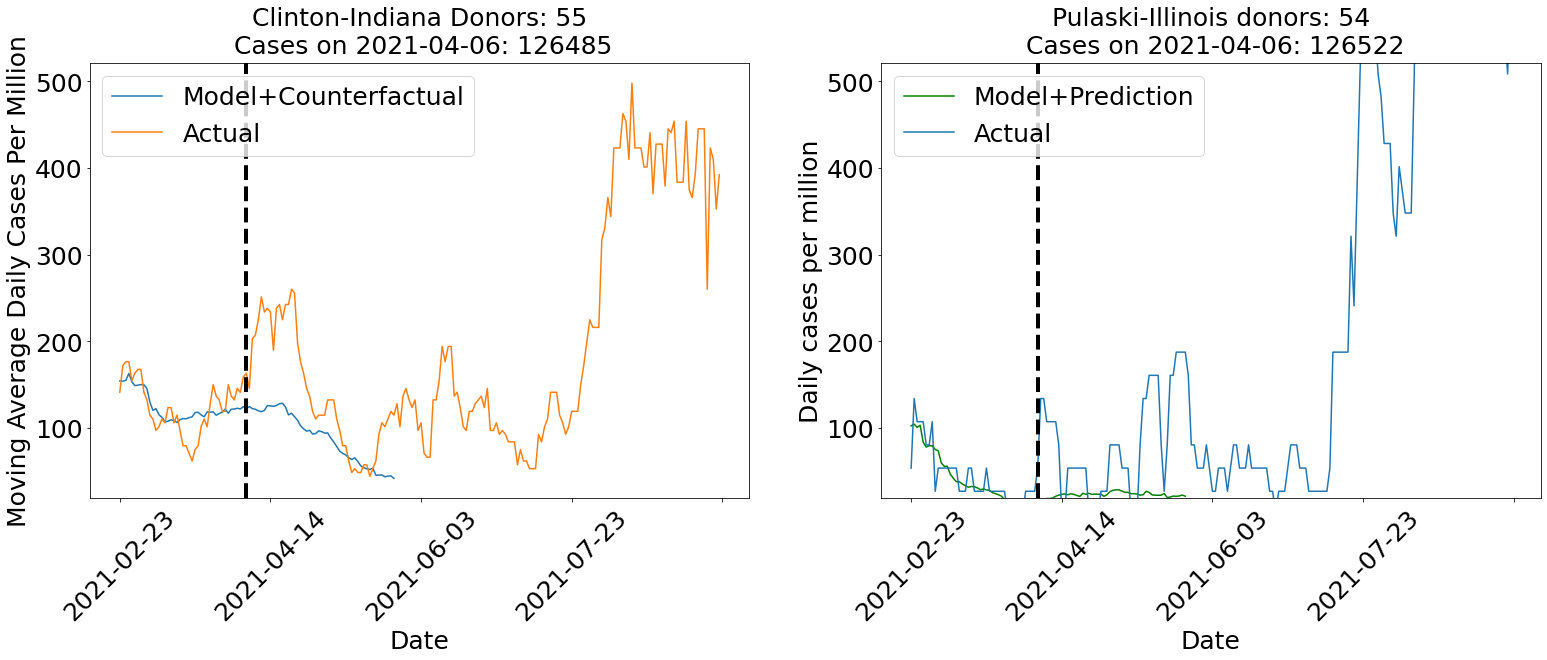

176
194
Daviess-Indiana 79.4899877555457


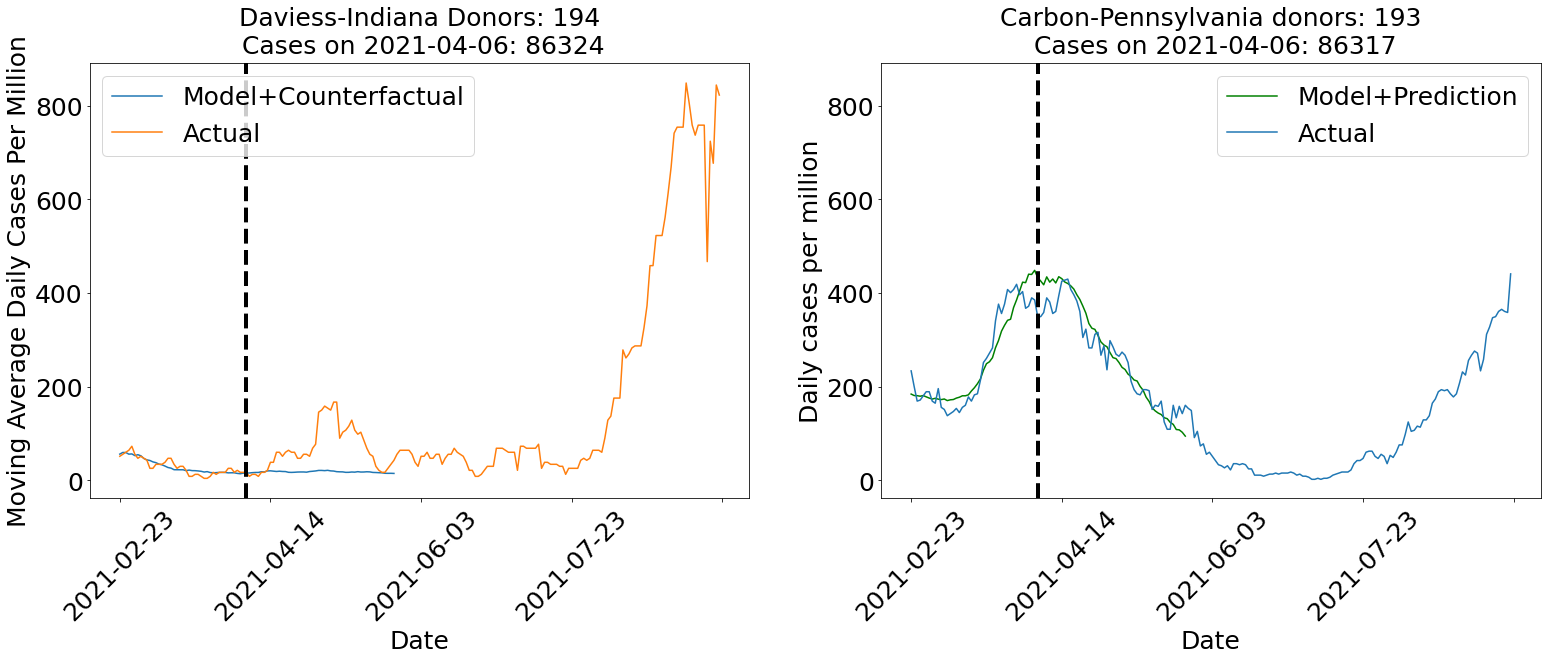

180
118
152
187
29
Dubois-Indiana 342.34042502417276


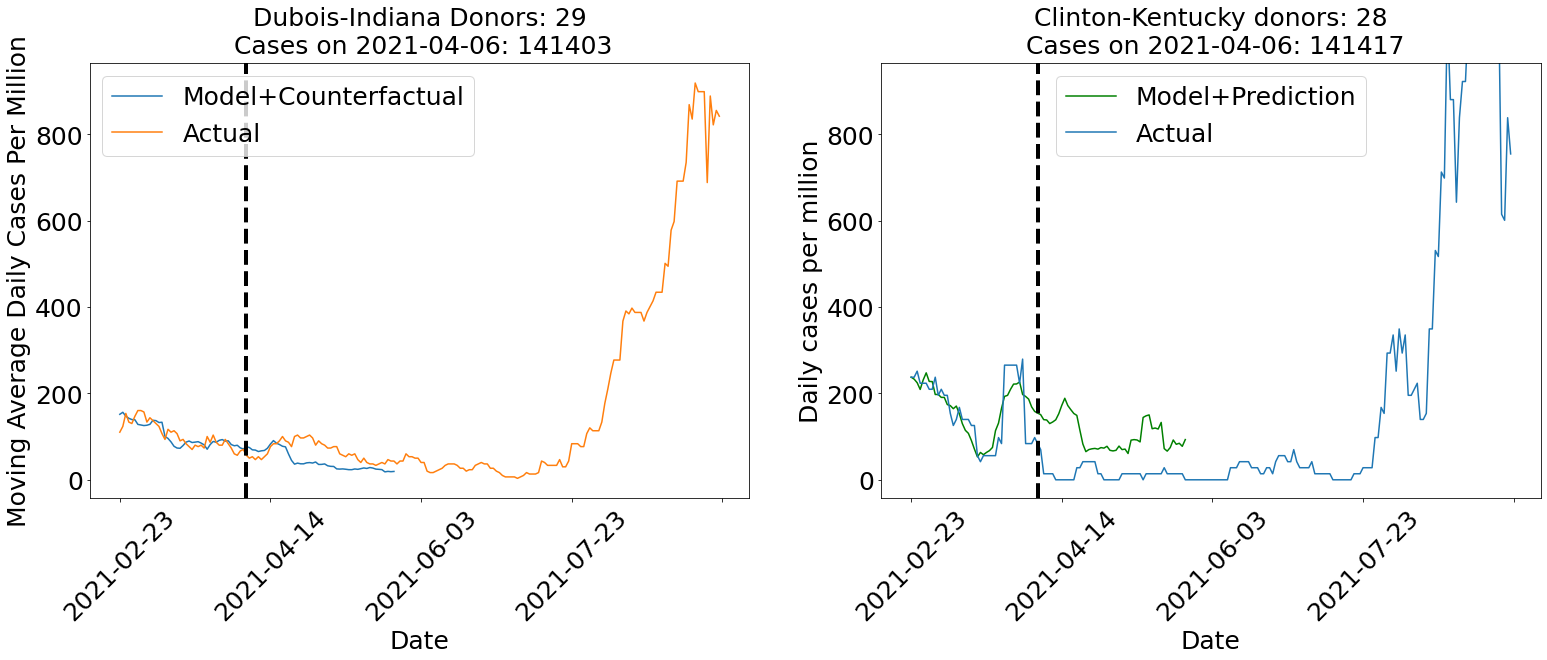

47
Elkhart-Indiana 339.68525011490857


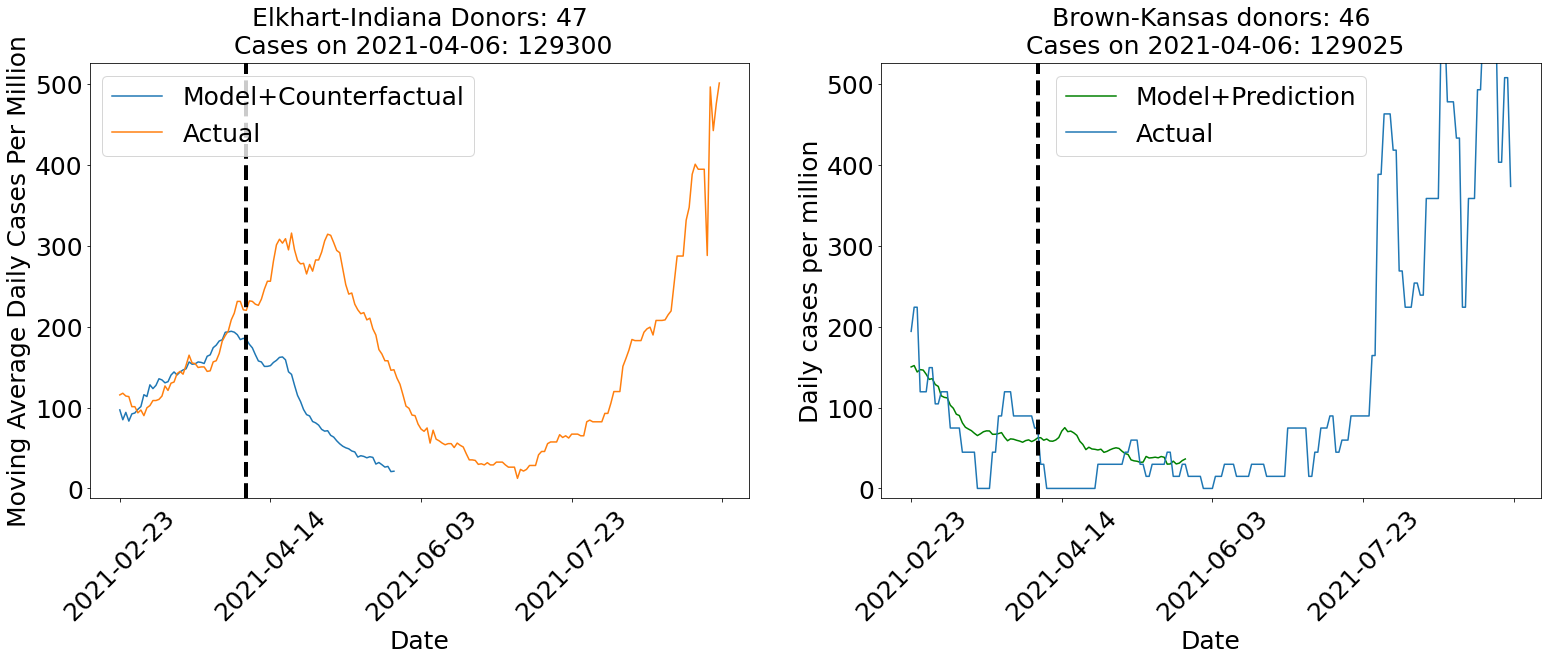

59
Fayette-Indiana 333.84535720791666


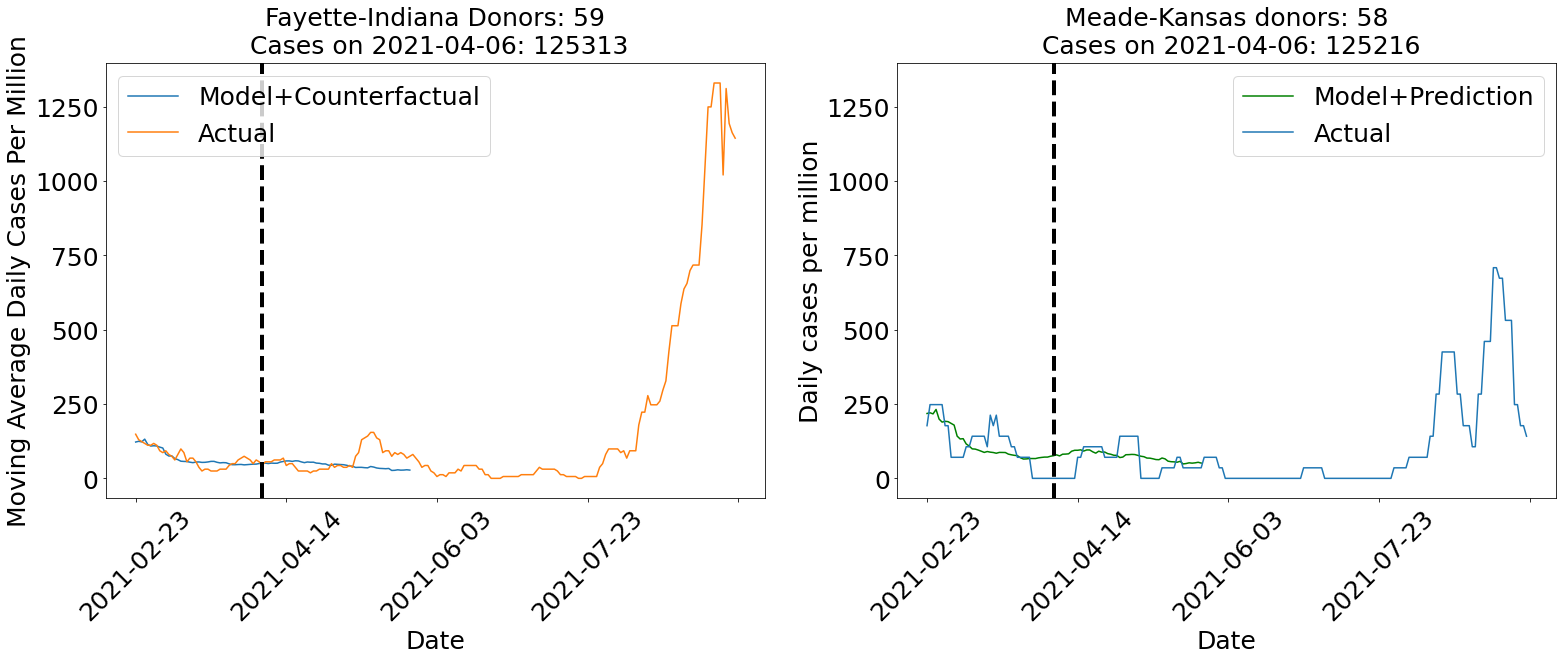

172
55
Fountain-Indiana 1309.7420181130276


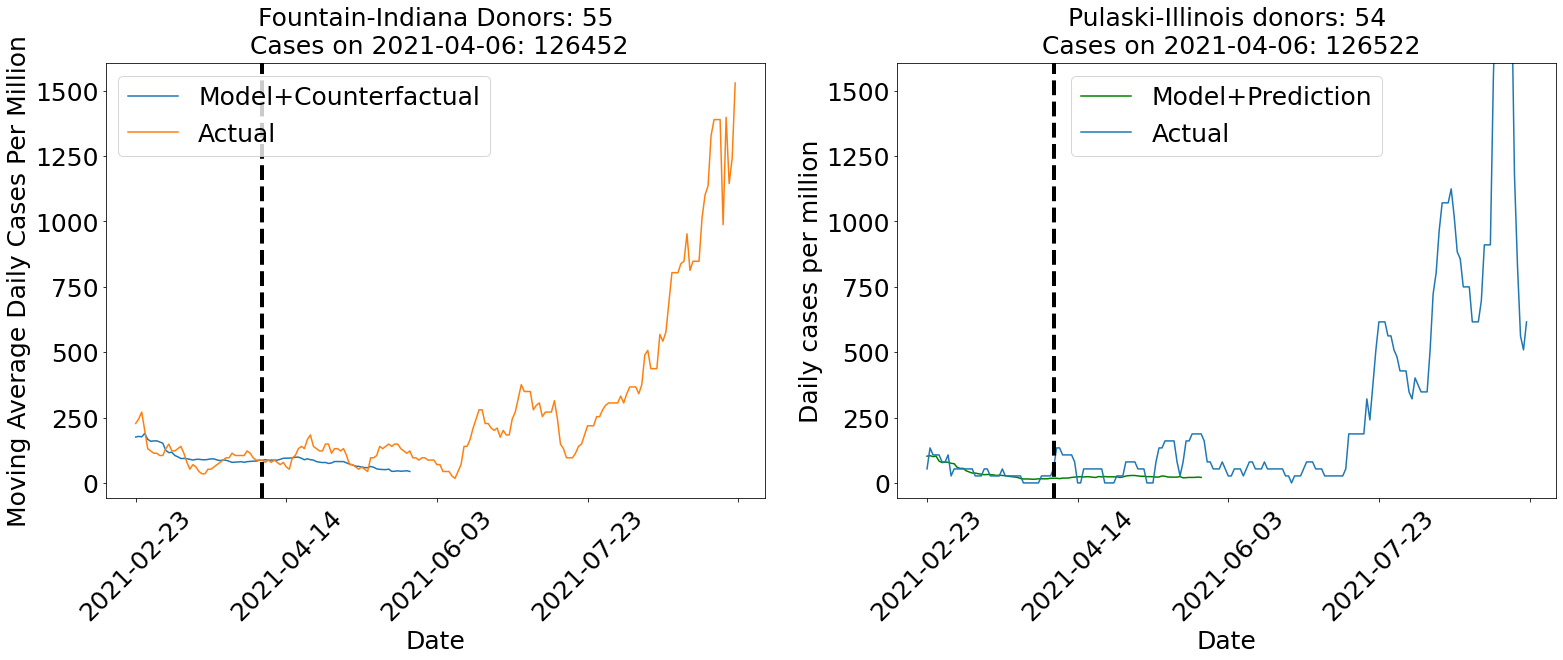

118
180
58
Gibson-Indiana 4255.408096865721


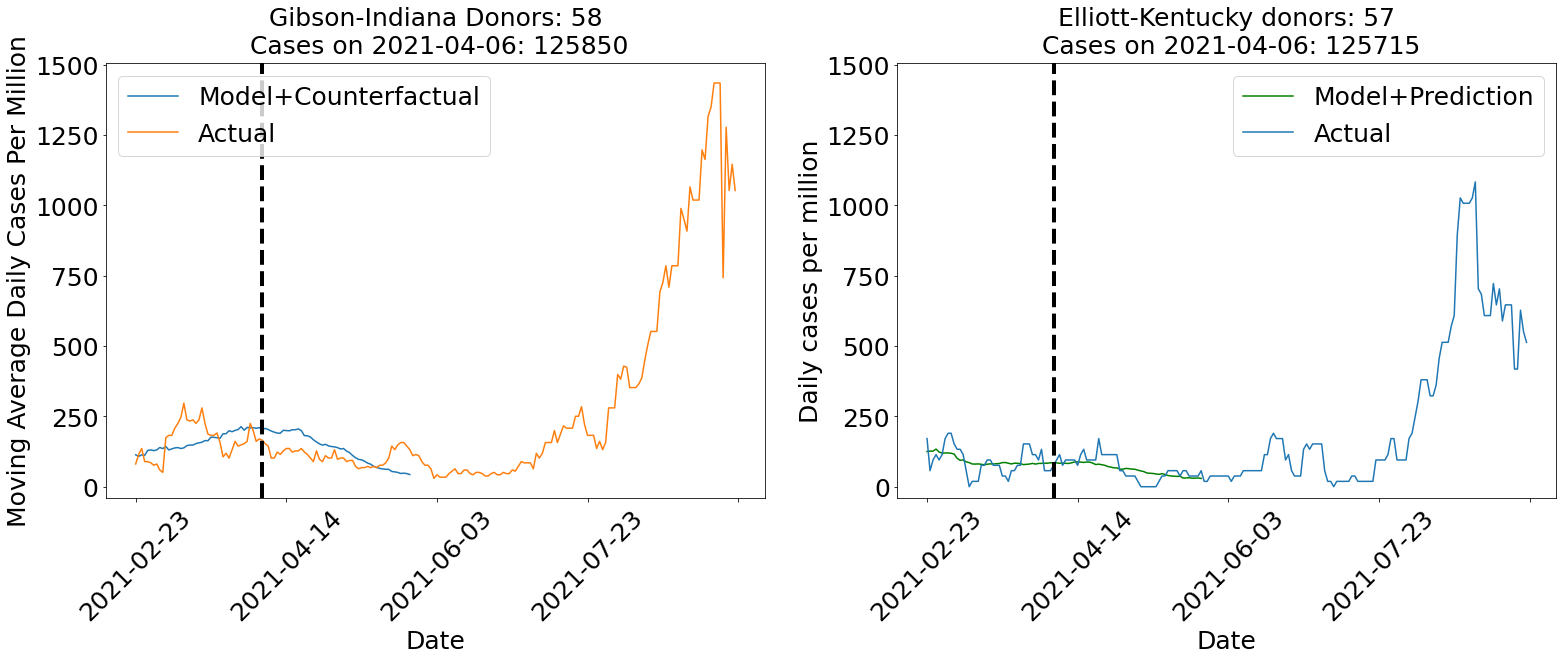

139
186
Greene-Indiana 443.14516171680356


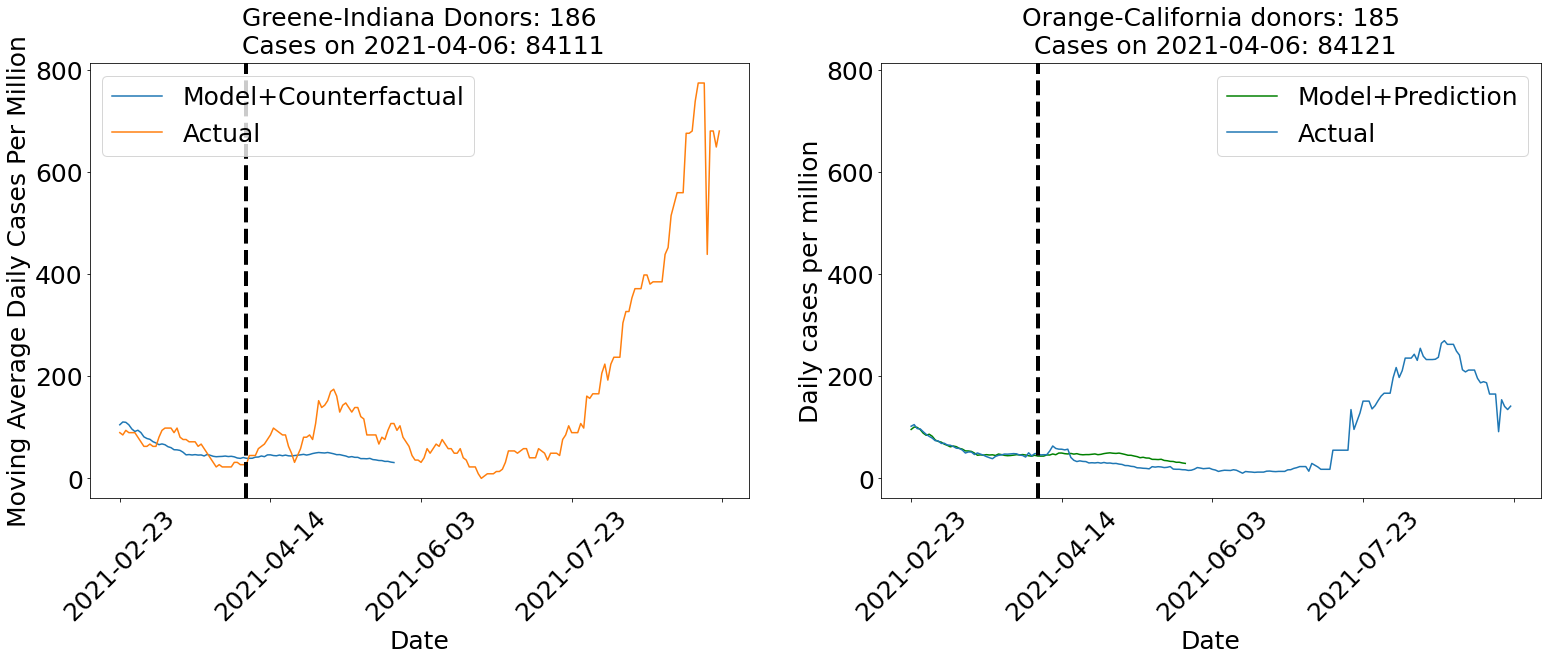

168
Hamilton-Indiana 639.579413450057


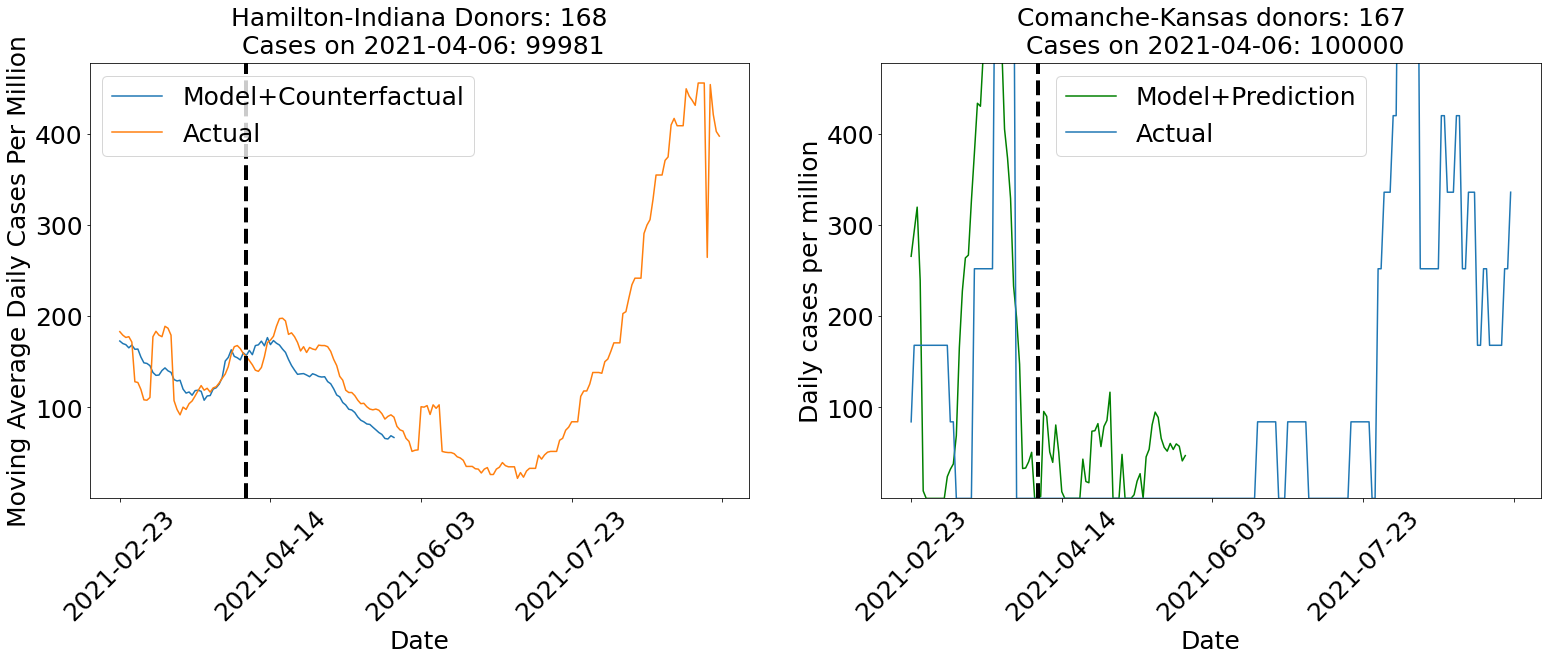

174
Hancock-Indiana 369.5247083074927


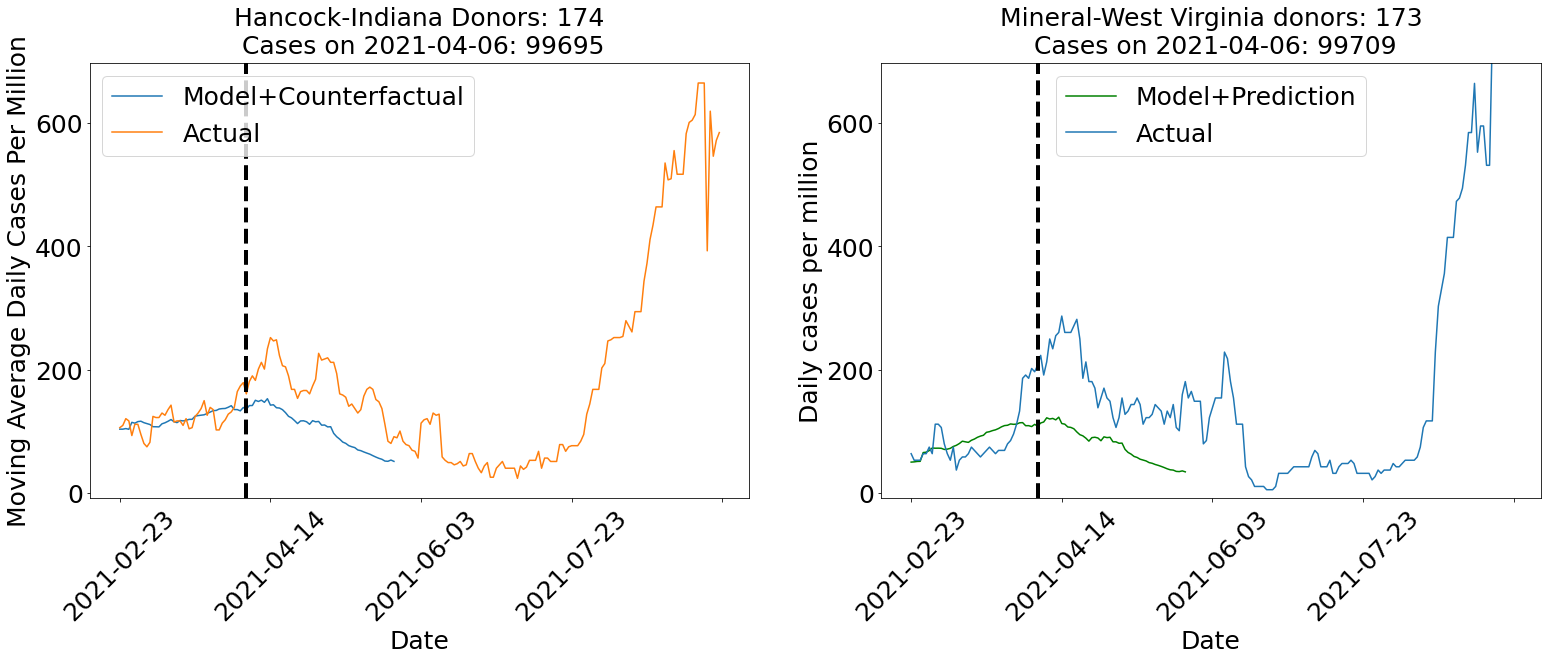

162
185
110
Henry-Indiana 266.16509485895284


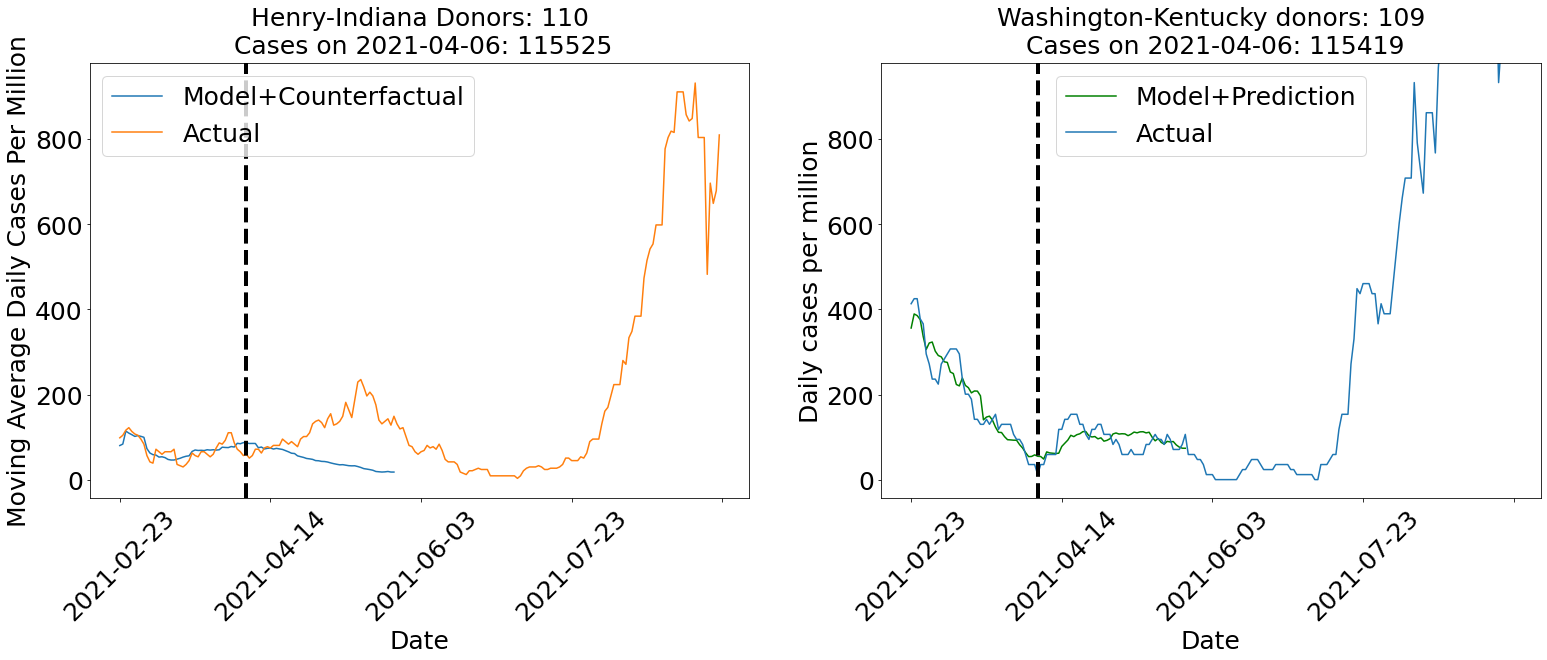

112
169
Huntington-Indiana 701.6405586069552


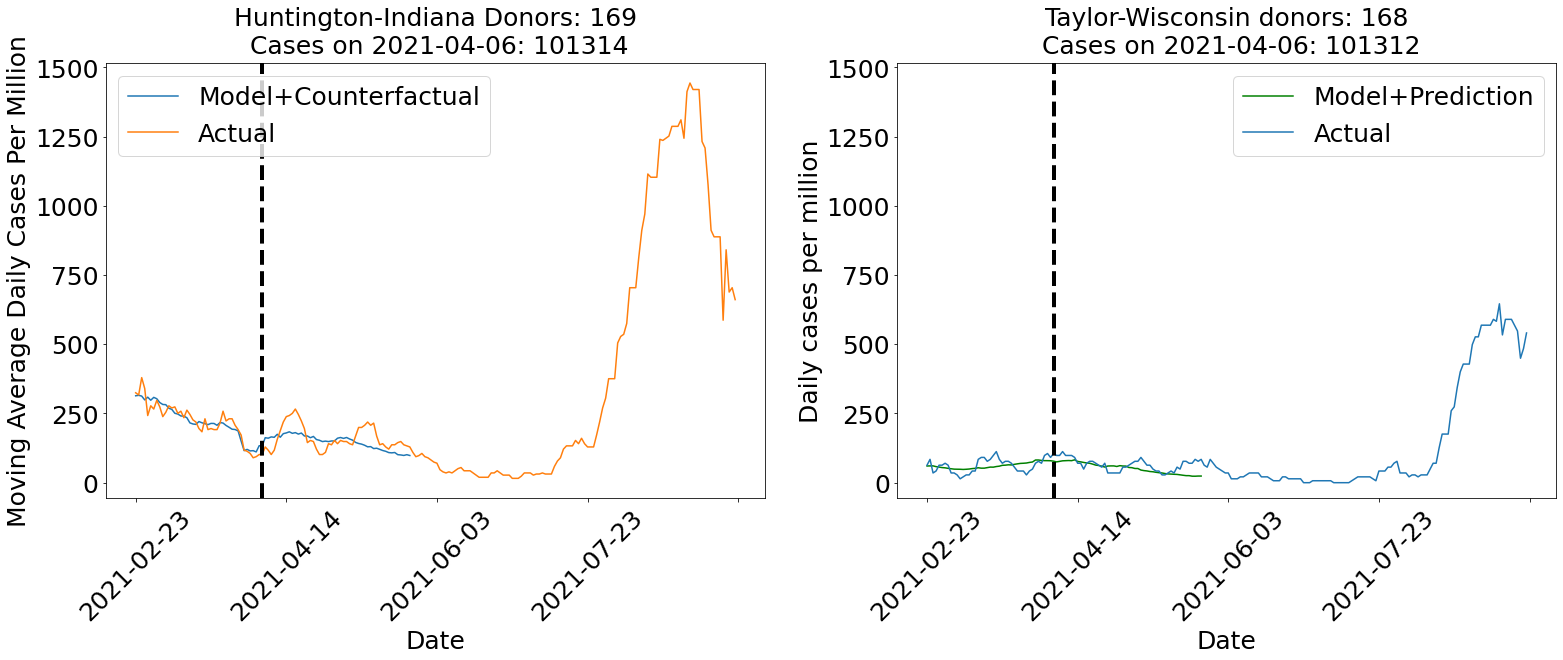

127
172
Jasper-Indiana 2326.4203086887155


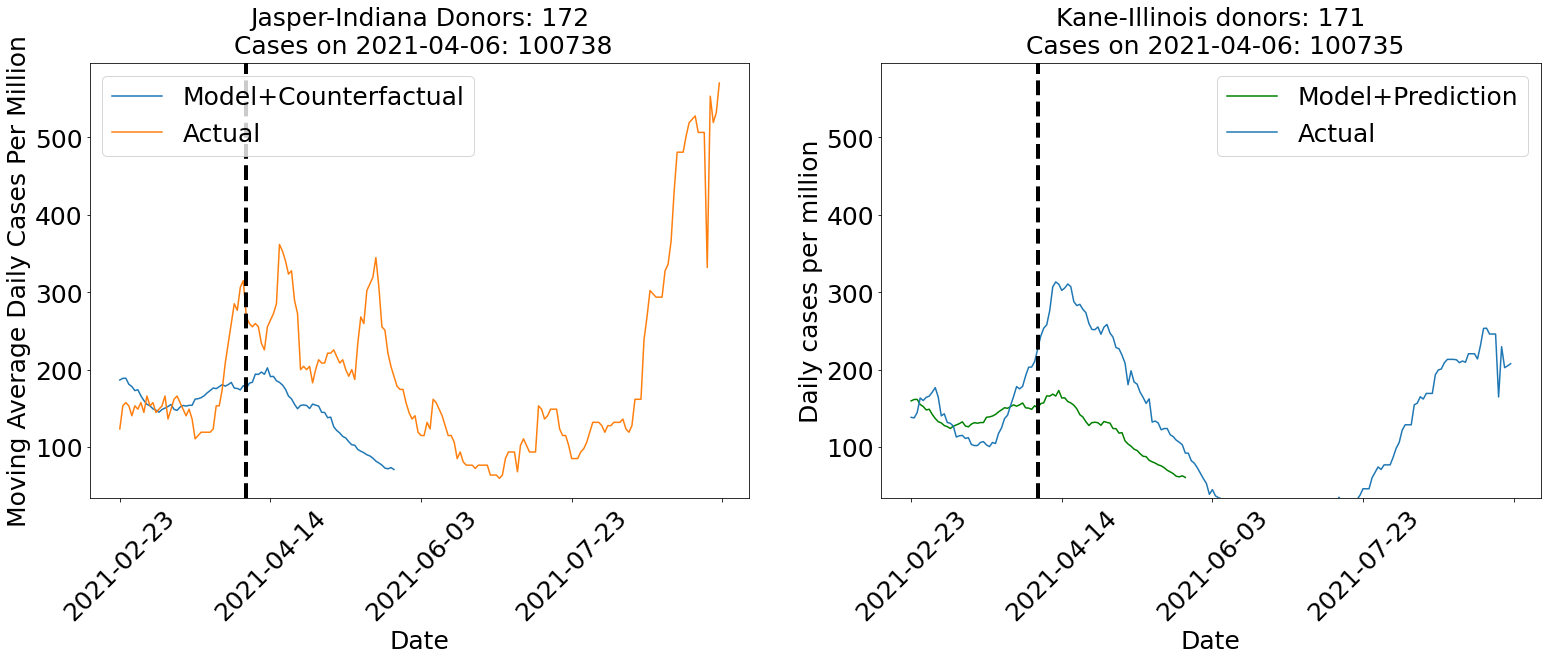

185
180
185
Jennings-Indiana 764.137057873042


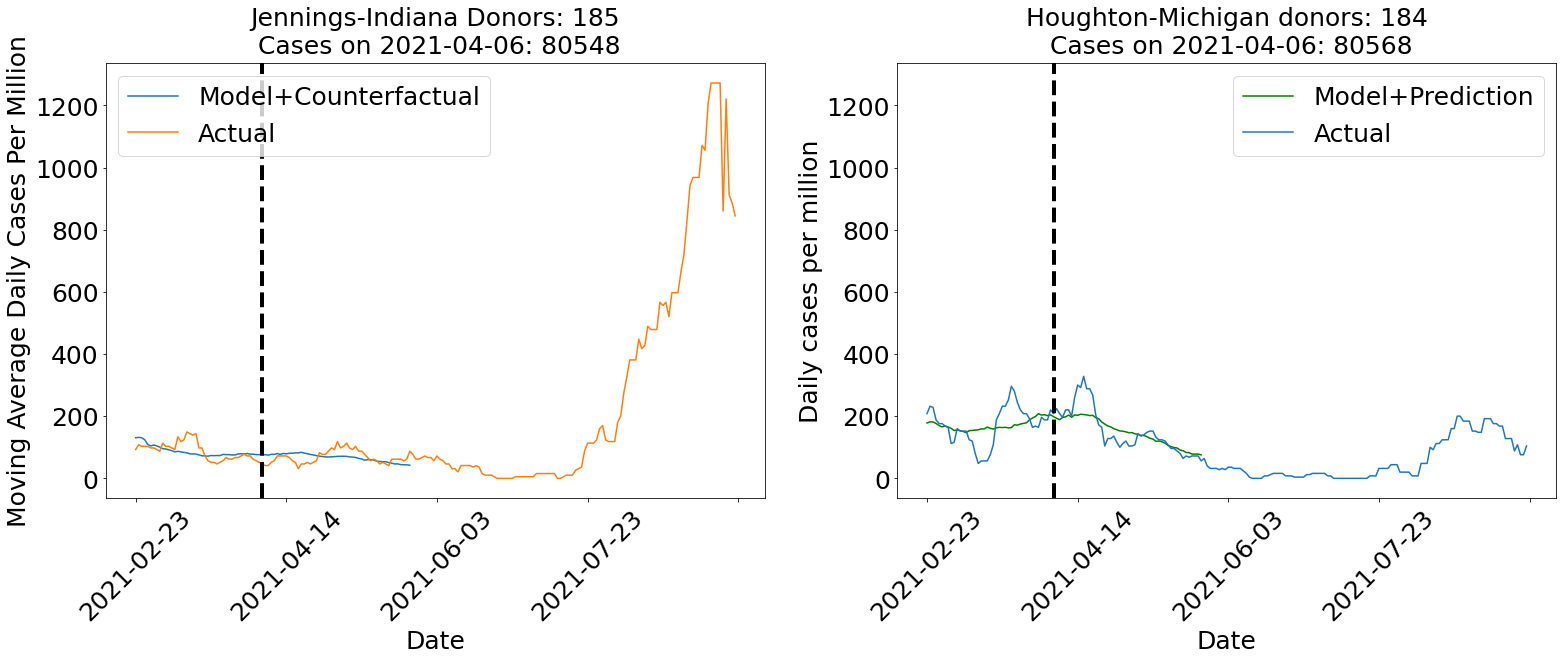

132
175
Knox-Indiana 759.3846118138897


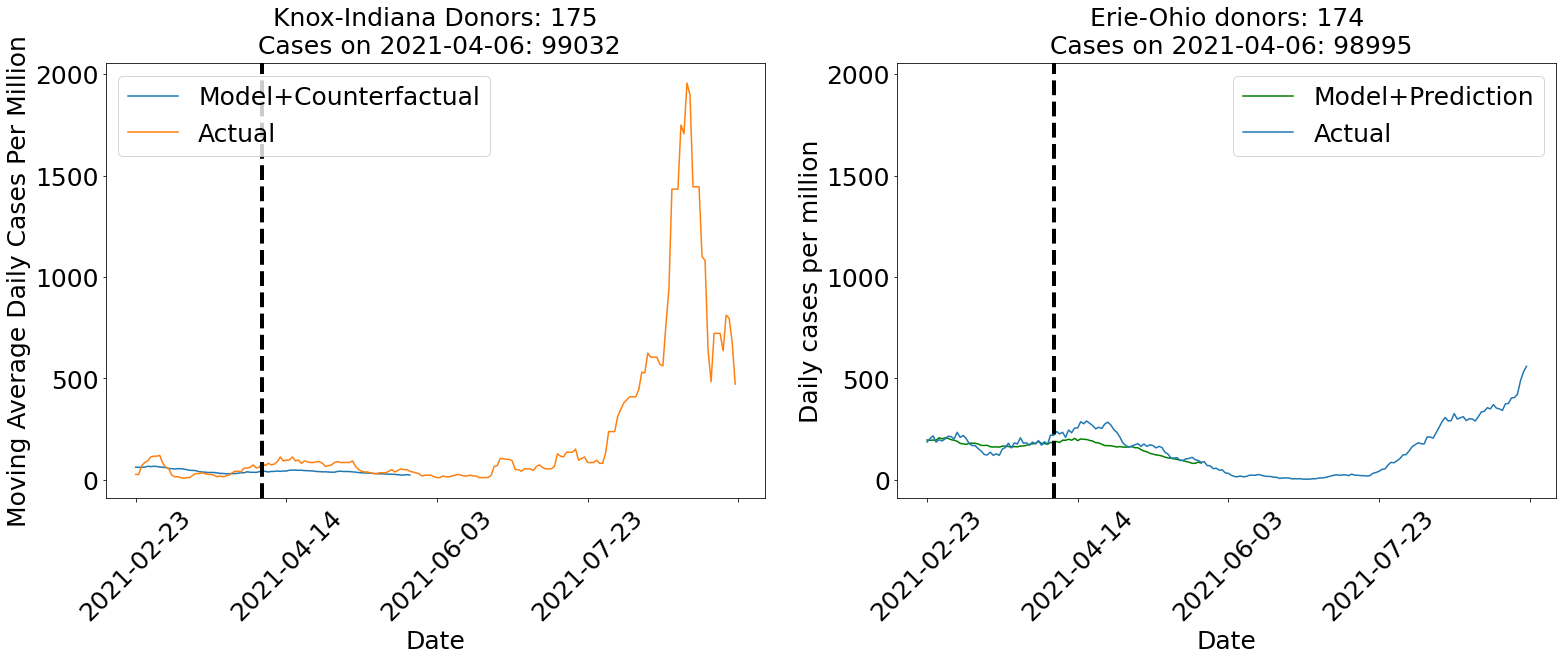

114
73
LaGrange-Indiana 134.351918729303


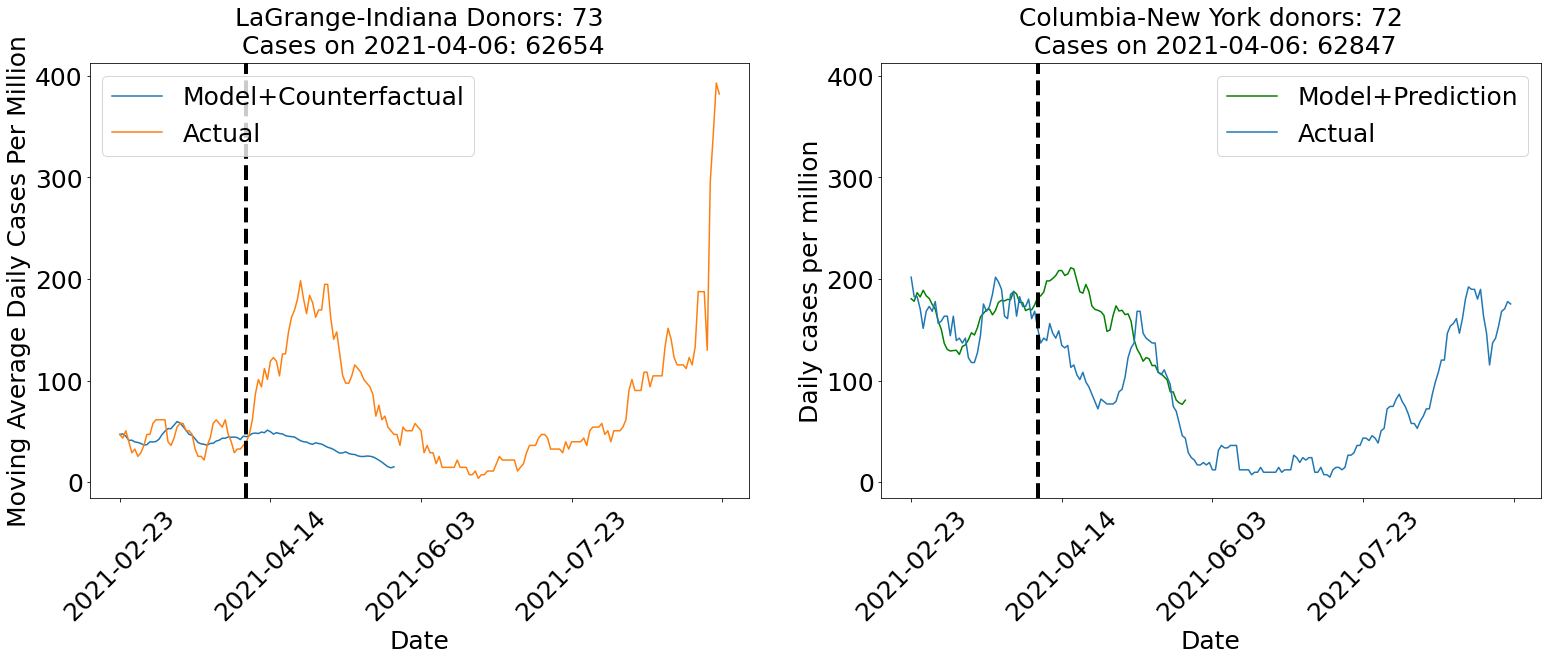

173
161
Lake-Indiana 83.50357273086058


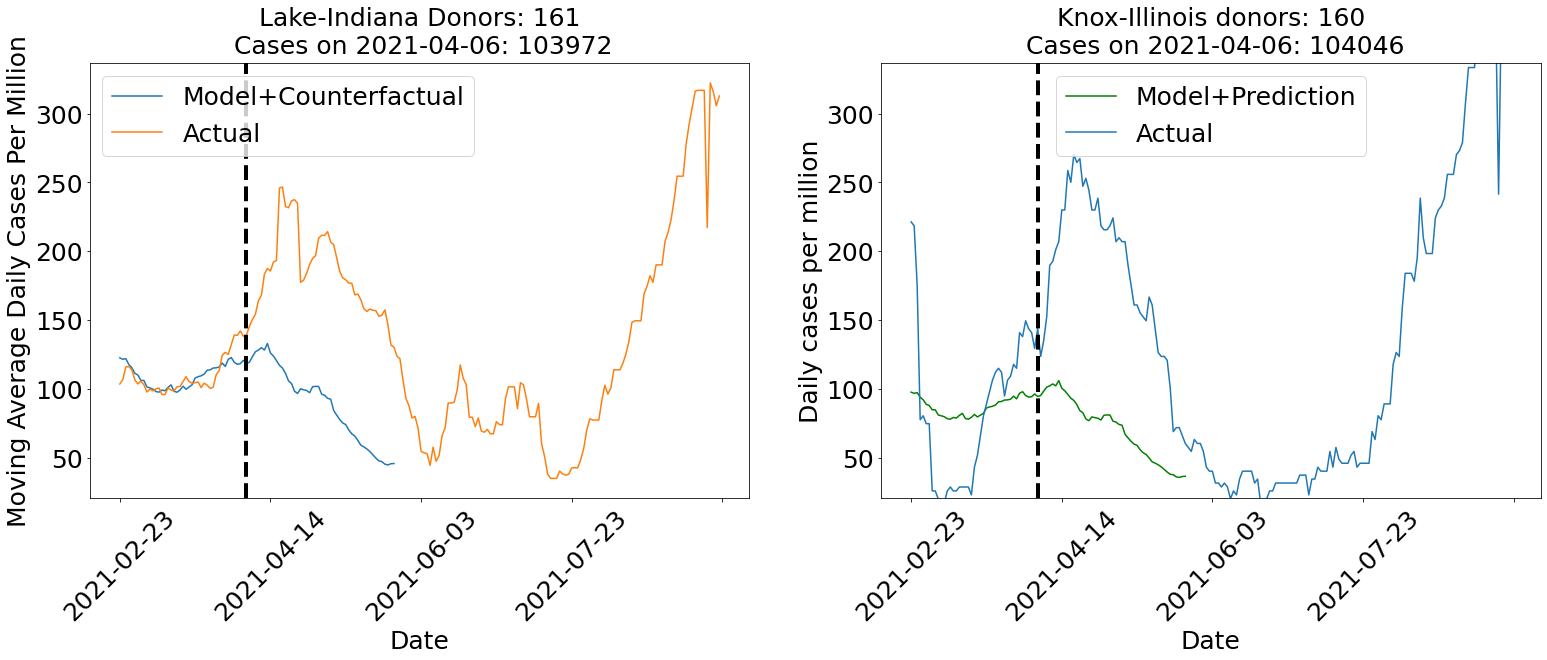

177
178
184
74
Marshall-Indiana 473.74613921052253


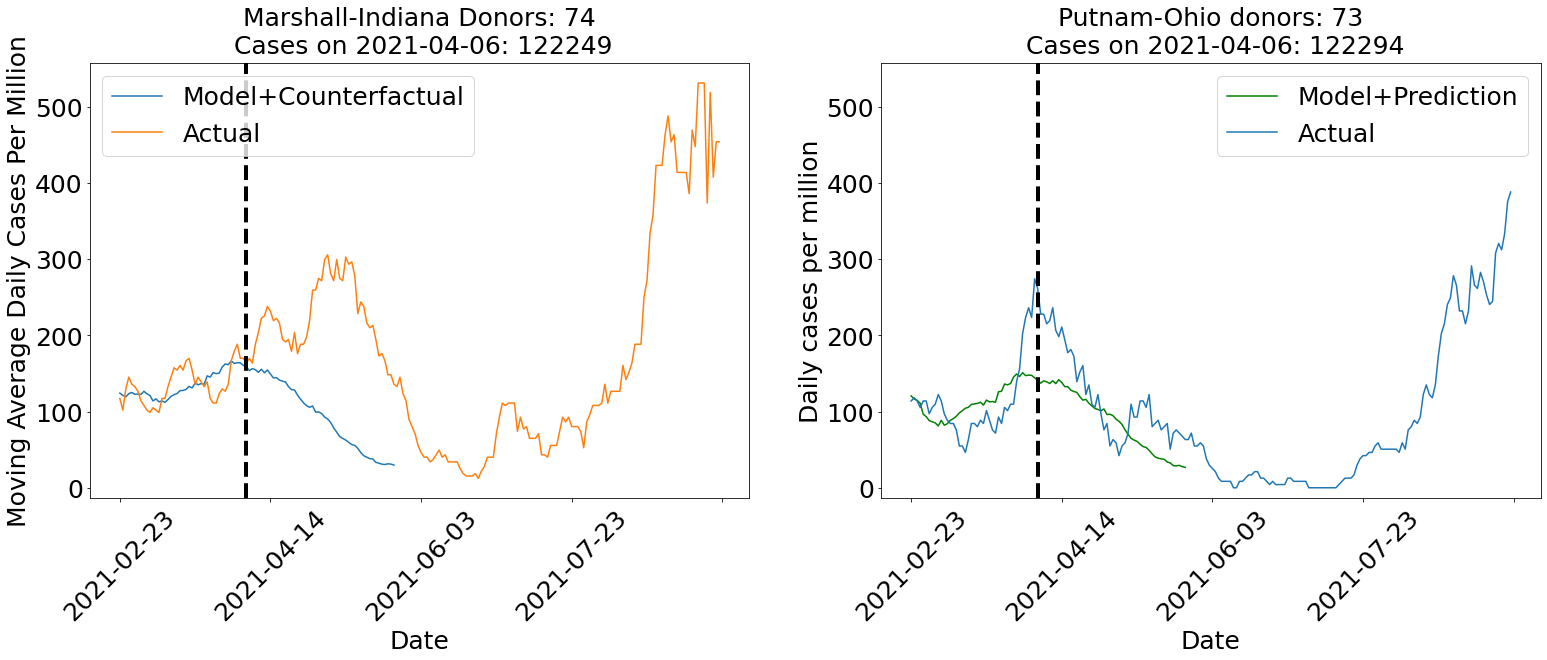

178
Martin-Indiana 386.2830965295102


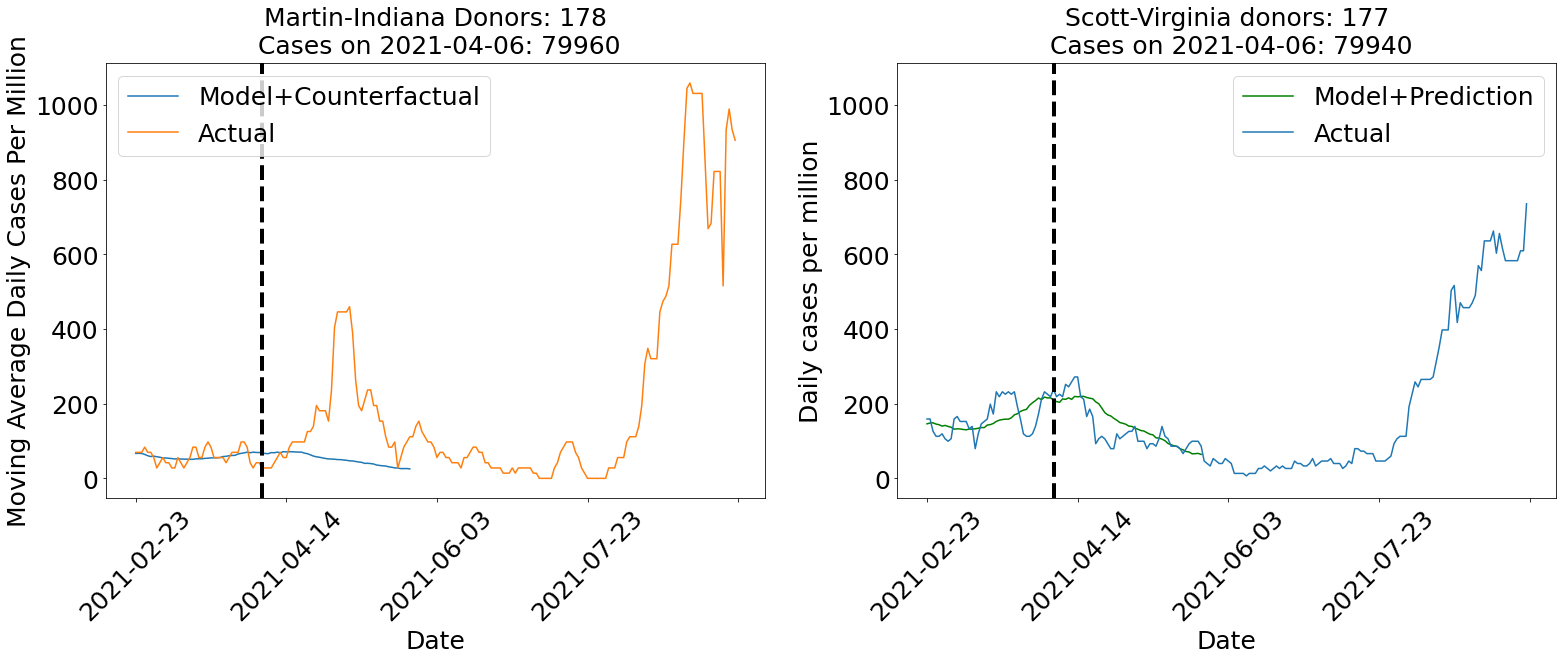

162
Miami-Indiana 953.8648092820014


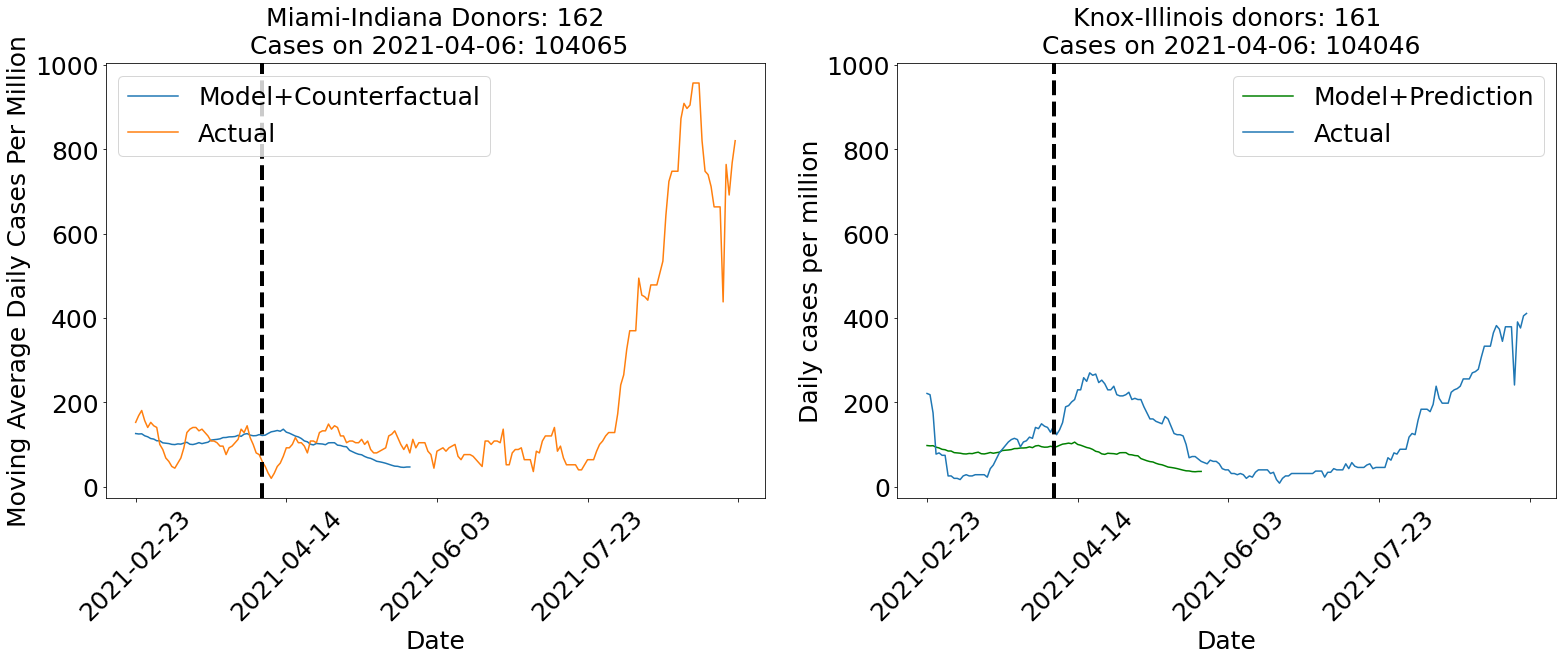

128
150
187
118
128
180
187
181
190
Parke-Indiana 578.6999076721685


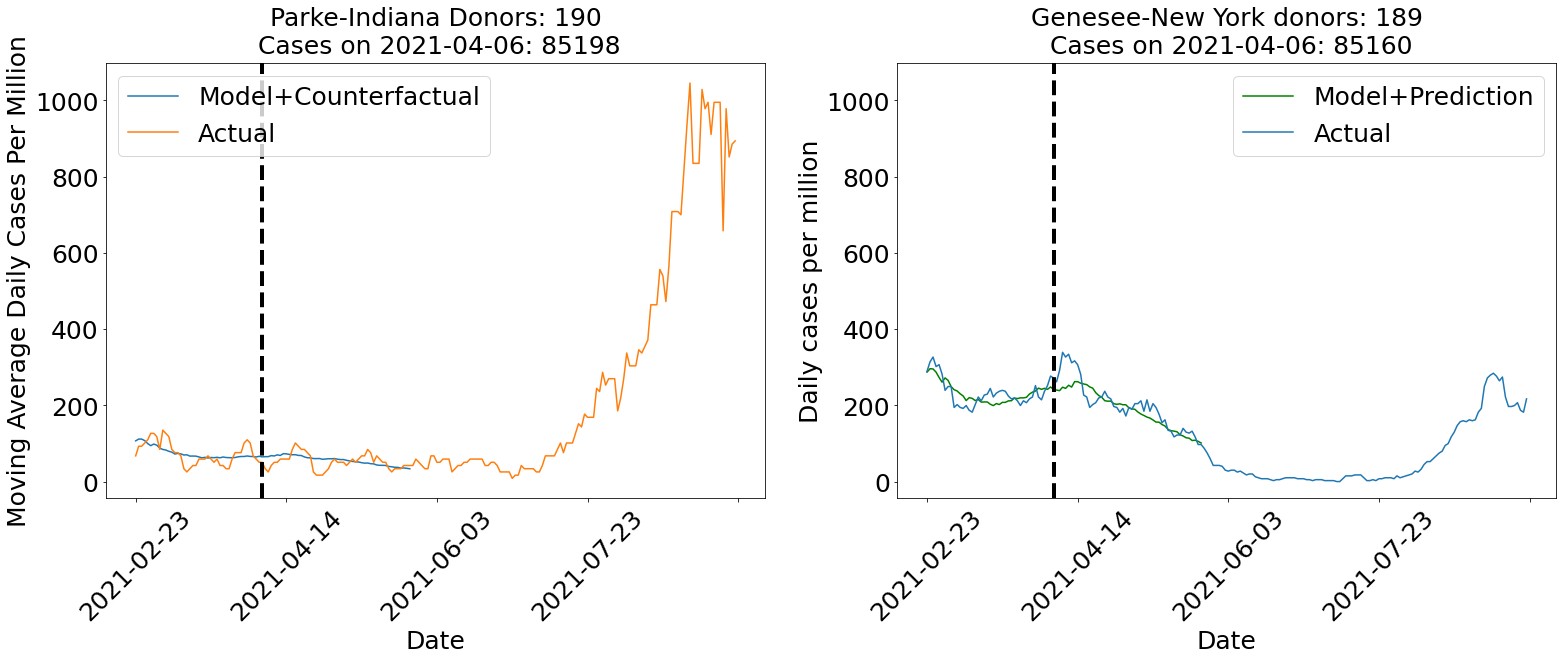

181
163
173
Porter-Indiana 313.6706888057722


In [ ]:

#df = df[df.columns[(df>100).any()]].copy()

data_df = all_cases_data_pop_daily.loc[start_date:].iloc[:200]
df_pop = all_cases_data_pop.loc[start_date:].iloc[:200]
prediction_range = 50

plt.rcParams.update({'font.size': 30})
tick_spacing = 50
FONTSIZE = 25

temp = mask_df[target_state].loc[start_date:].iloc[:date_range]
intervention_date = np.arange(1, len(temp))[np.diff(temp) < 0][0]
if intervention_date < 30:
    print("Not Enough training date")
    pass

low_thresh = np.minimum(intervention_date, 50)
cur_data_df = data_df.iloc[np.maximum(0, intervention_date - 50):]
cur_pop_df = df_pop.iloc[np.maximum(0, intervention_date - 50):]


# targets = ['Jefferson-Louisiana', 'Bartholomew-Indiana' , \
#            'Broward-Florida', 'Riverside-California', 'Crisp-Georgia', \
#            'Bullock-Alabama']#counties_recommended #counties_recommended

#targets = list(df_pop.loc[low_thresh_date, targets].sort_values().keys())

singVals=6

num_rows_to_plot = int(len(targets))+1
#plt.rcParams['figure.figsize'] = (24, num_rows_to_plot*5.0)
plt.rcParams['figure.figsize'] = (26, 8.0)

mask_mandate_model = []
target_model = []

i=1
print("Counterfactual analysis of Mask recommended counties based on a donor pool of Mask mandated counties")

for state in targets:
    #otherStates = donors.copy()
    otherStates = cur_pop_df.columns[(cur_pop_df.iloc[low_thresh] < 
                                  cur_pop_df[state].iloc[low_thresh]+0.05*cur_pop_df[state].iloc[low_thresh])
                                &(cur_pop_df.iloc[low_thresh] > cur_pop_df[state].iloc[low_thresh]-0.05*cur_pop_df[state].iloc[low_thresh])]
    
    otherStates = list(otherStates[otherStates.isin(donors)])
    print(len(otherStates))
    

    if state in otherStates:
        otherStates.remove(state)
    if (len(otherStates)<5):
        print(len(otherStates))
        continue
        
    try:

        rscModel = syn_model(state, singVals, [cur_data_df], low_thresh + prediction_range, low_thresh, otherStates=otherStates)
        rscModel.fit_model(filter_donor = True, filter_method = 'hbo', singVals_estimate = True, singval_mathod ='auto')
        target_model.append(rscModel)
    except:
        continue
        
    predictions = rscModel.predictions
    model_fit = rscModel.model_fit

    #print(state, fit_error, prediction_error)
    if(len(otherStates)<5):
        print(otherStates)
        continue
    if(rscModel.train_err > 60):
        print(state, rscModel.train_err)
    else:
        print(state)

    #ax = plt.subplot(num_rows_to_plot,2,2*i-1)
    ax = plt.subplot(1,2,1)
    #fig, ax = plt.subplots(1,1)
        
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.set_title(state+" Donors: "+str(len(otherStates))
                 + "\n Cases on "+ cur_pop_df.index[low_thresh]+ ": " + str(int(cur_pop_df[state].iloc[low_thresh])) ,fontsize=FONTSIZE, pad=10)
    plt.plot(np.concatenate((model_fit, predictions)), label='Model+Counterfactual'), plt.plot(cur_data_df[state], label='Actual'), 
    plt.ylabel('Moving Average Daily Cases Per Million',fontsize=FONTSIZE),
    plt.axvline(x=cur_data_df.index[low_thresh], color='k', linestyle='--', linewidth=4), plt.legend(fontsize=FONTSIZE)
    plt.xlabel('Date',fontsize = FONTSIZE )
    plt.xticks(rotation=45, fontsize = FONTSIZE), plt.yticks(fontsize = FONTSIZE) 
    y_min, y_max = ax.get_ylim()
    
    new_state = otherStates[np.argmin(np.abs(cur_pop_df[otherStates].iloc[low_thresh]-cur_pop_df[state].iloc[low_thresh]))]
    #otherStates = df.columns[(df.iloc[low_thresh] < df[new_state].iloc[low_thresh]+
    #                          .5*df[new_state].iloc[low_thresh])&(df.iloc[low_thresh] > df[new_state].iloc[low_thresh]-0.5*df[new_state].iloc[low_thresh])]
    #otherStates = list(otherStates[otherStates.isin(donors)])
    #print(state, "\n", len(otherStates))
    
    if new_state in otherStates:
        otherStates.remove(new_state)
    
    try:

    
        rscModel2 = syn_model(new_state, singVals, [cur_data_df], low_thresh + prediction_range, low_thresh, otherStates=otherStates)

        rscModel2.fit_model(filter_donor = True, filter_method = 'hbo', singVals_estimate = True, singval_mathod ='auto')



        mask_mandate_model.append(rscModel2)
    except:
        continue
    
    predictions = []
    
    predictions = rscModel2.predictions
    model_fit = rscModel2.model_fit
    
    #ax = plt.subplot(num_rows_to_plot,2,2*i)
    ax = plt.subplot(1,2,2)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.set_title(new_state+" donors: "+str(len(otherStates))
                 + "\n Cases on "+ cur_pop_df.index[low_thresh]+ ": " + str(int(cur_pop_df[new_state].iloc[low_thresh])) ,fontsize=FONTSIZE, pad=10)

    plt.plot(np.concatenate((model_fit, predictions)), color='green', label='Model+Prediction'),
    plt.plot(cur_data_df[new_state], label='Actual'), plt.legend(fontsize = FONTSIZE), 
    plt.ylabel('Daily cases per million',fontsize = FONTSIZE),
    plt.ylim([y_min, y_max])
    plt.axvline(x=cur_data_df.index[low_thresh], color='k', linestyle='--', linewidth=4), plt.legend(fontsize = FONTSIZE)
    #plt.savefig("../figures/"+state+".png")
    
    plt.xlabel('Date',fontsize = FONTSIZE )
    plt.xticks(rotation=45, fontsize = FONTSIZE), plt.yticks(fontsize = FONTSIZE) 
    
    i=i+1
    #plt.savefig('../Figures/COVID/'+state+'_'+new_state+'.pdf', bbox_inches='tight')

    plt.show()
    

## Prediction of Delta variant by SC

### Predict after the discovery date

In [114]:

## Align the data set by discovery date of delta
df = all_cases_data_pop_daily

target = "Italy"
target_start = delta_variant_data.loc[target].values[0]
tick_spacing = 90
filter_donor_by_date = False
singVals = 6


## Use the county with delta discovery date earlier than target
if filter_donor_by_date:

    donors = list(delta_variant_data.loc[delta_variant_data['Date'] < target_start].index)
    
else:
    
    donors = list(delta_variant_data.index)
    donors.remove(target)

donor_start = delta_variant_data.loc[donors].values.flatten()

prediction_length = 120

train_length = 50

donor_start_idx = [list(df.index).index(date) - train_length for date in donor_start]
donor_end_idx =  [list(df.index).index(date) + prediction_length for date in donor_start]

target_start_idx = list(df.index).index(target_start) - train_length
target_end_idx = list(df.index).index(target_start) + prediction_length

data_df = df[target][target_start_idx:target_end_idx]
idx = data_df.index
data_df = pd.Series(data_df.values, name = target)
#print(data_df.shape)

for i in range(len(donors)):
    temp_df = df[donors[i]][donor_start_idx[i]:donor_end_idx[i]]
    data_df = pd.concat([data_df, pd.Series(temp_df.values, name = donors[i])], axis = 1)
    
data_df.index = idx



### Original

['France', 'Ireland', 'Germany', 'Denmark', 'Belgium', 'Sweden', 'Switzerland', 'Portugal', 'Norway', 'United Kingdom', 'Finland', 'Korea, South', 'Japan', 'Netherlands', 'Luxembourg', 'Austria', 'Slovenia', 'Russia', 'US', 'Spain', 'Czechia', 'Poland', 'Turkey'] 3


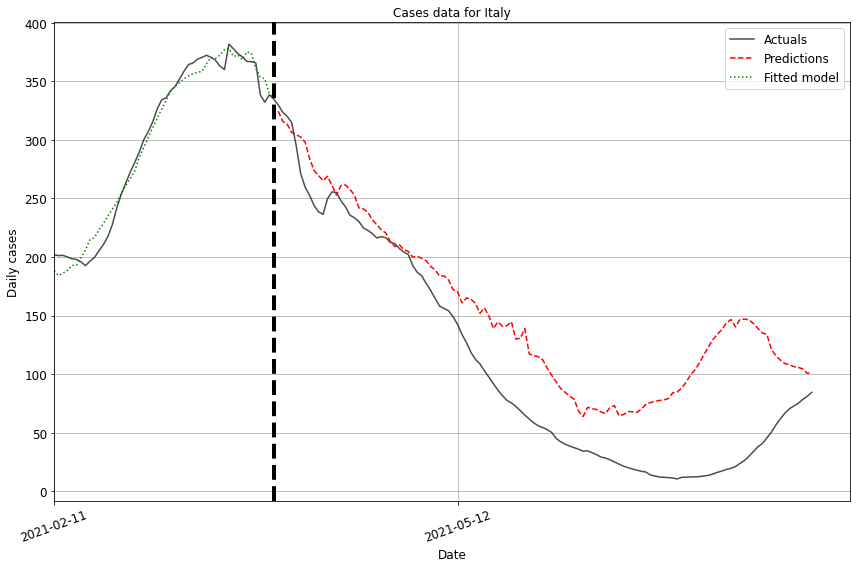

In [115]:
# sc model using the discovery date as intervention date
rscModel =syn_model(target, singVals, [data_df], train_length + prediction_length, train_length, otherStates=donors)
rscModel.fit_model(filter_donor = False, filter_method = 'percentile', singVals_estimate = True, singval_mathod ='auto')

predictions = rscModel.predictions
model_fit = rscModel.model_fit

fig, axes = plt.subplots(1, 1, figsize = (12, 8))

rscModel.plot(figure=fig, axes=axes, title_text="Cases data", ylimit=[], xlimit=[], logy=False, show_donors=False, tick_spacing=tick_spacing, xaxis="Date", yaxis="Daily cases", intervention_date_x_ticks=None, fontsize = 12)
#plt.savefig("../Figures/COVID/"+county_state+".png",bbox_inches='tight')    
plt.tight_layout()

print(rscModel.donors, rscModel.kSingularValues)

plt.show()

### HBO

outliers: ['France' 'Korea, South' 'Japan' 'Russia' 'Spain']


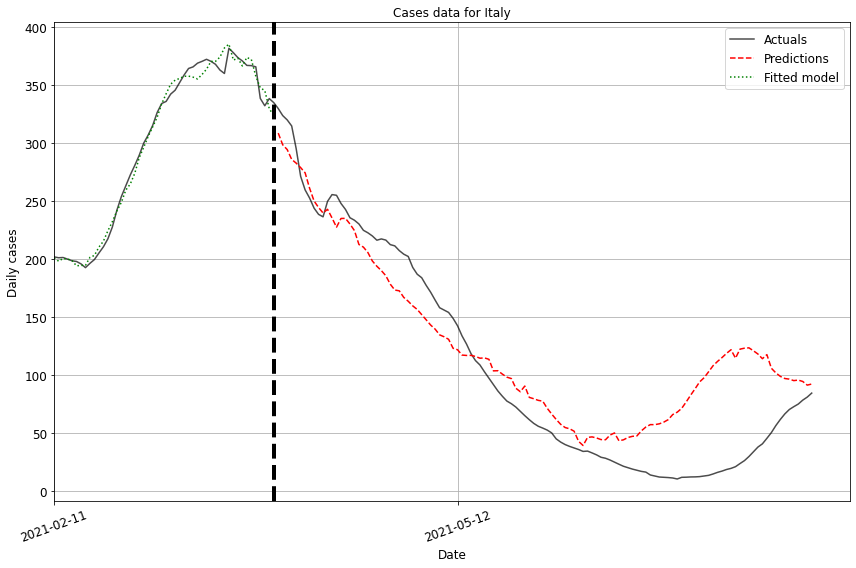

In [116]:
perm_dict = rscModel.permutation_distribution(show_graph = False, include_self = False, ri_method = 'ratio')
train_perm_dict = permutation_train_test(rscModel)
train_values = np.array(list(perm_dict.values()))

test_perm_dict = permutation_train_test(rscModel, train_err = False)
test_values = np.array(list(perm_dict.values()))

all_donors = np.array(list(perm_dict.keys()))
values = np.array(list(perm_dict.values()))

input_df =  pd.DataFrame([train_values,test_values]).transpose() # pd.DataFrame(values)
hbos = HBOS(alpha=0.1, contamination=0.15, n_bins=20, tol=0.5)
hbos.fit(input_df)
output = hbos.decision_function(input_df)
res = hbos.predict(input_df)
res = np.array(res, dtype = bool)

print('outliers:', all_donors[res])
# for item in all_donors[res]:
#     if item in outliers:
#         TP+=1
#     else:
#         FP+=1

################################################
################################################

rscModel2 =syn_model(target, singVals, [data_df], train_length + prediction_length, train_length, otherStates=list(all_donors[~res]))
try:
    rscModel2.fit_model(filter_donor = False, singVals_estimate = True, singval_mathod ='auto')
except Exception as e: 
    print(e)

fig, axes = plt.subplots(1, 1, figsize = (12, 8))

rscModel2.plot(figure=fig, axes=axes, title_text="Cases data", ylimit=[], xlimit=[], logy=False, show_donors=False, tick_spacing=tick_spacing, xaxis="Date", yaxis="Daily cases", intervention_date_x_ticks=None, fontsize = 12)
#plt.savefig("../Figures/COVID/"+county_state+".png",bbox_inches='tight')    
plt.tight_layout()

plt.show()

### Backward



target: Italy
donors: 23 removed: ['Poland']
training error before: 98.87742713456379 training error after: 194.33105973914593


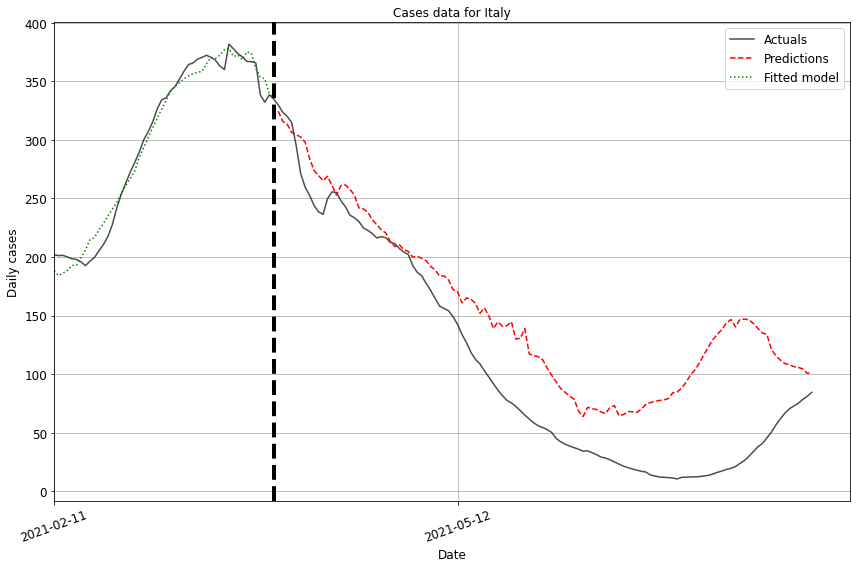

In [117]:
rscModel1 = rscModel
final_donors = rscModel1.donors
print('\n\ntarget:', target)
while len(final_donors)>3:
    #rscModel =syn_model(state, singVals, [df], high_thresh, low_thresh, otherStates=otherStates)
    #rscModel.fit_model(filter_donor = False, singVals_estimate = True, singval_mathod ='auto')
    #train_err1 = rscModel.train_err
    new_donors = backward_donor_elimination(rscModel1, metric=mean_squared_error, output = 'training_error')

    '''
    print(new_donors)
    rscModel1 =syn_model(state, singVals, [df], high_thresh, low_thresh, otherStates=final_donors)
    rscModel1.fit_model(filter_donor = False, singVals_estimate = True, singval_mathod ='auto')
    '''
    rscModel2 =syn_model(target, singVals, [data_df], train_length + prediction_length, train_length, otherStates=list(new_donors))
    #temp_model=syn_model(rscModel.state, rscModel.kSingularValues, rscModel.dfs, high_thresh, low_thresh, 
    #                    random_distribution = rscModel.random_distribution, lambdas = rscModel.lambdas, mRSC = rscModel.mRSC, otherStates=donorPool)

    rscModel2.fit_model(filter_donor = False, singVals_estimate = True, singval_mathod ='auto')

    print('training error before:', rscModel1.train_err,'training error after:', rscModel2.train_err)
    if rscModel1.train_err <= rscModel2.train_err:
        break
    final_donors = new_donors
    rscModel1 = rscModel2
    
fig, axes = plt.subplots(1, 1, figsize = (12, 8))

rscModel1.plot(figure=fig, axes=axes, title_text="Cases data", ylimit=[], xlimit=[], logy=False, show_donors=False, tick_spacing=tick_spacing, xaxis="Date", yaxis="Daily cases", intervention_date_x_ticks=None, fontsize = 12)
#plt.savefig("../Figures/COVID/"+county_state+".png",bbox_inches='tight')    
plt.tight_layout()


plt.show()

## "short prediction" after the discovery date

['France', 'Ireland', 'Germany', 'Denmark', 'Belgium', 'Sweden', 'Switzerland', 'Portugal', 'Norway', 'United Kingdom', 'Finland', 'Korea, South', 'Japan', 'Netherlands', 'Luxembourg', 'Austria', 'Slovenia', 'Russia', 'US', 'Spain', 'Czechia', 'Poland', 'Turkey'] 5


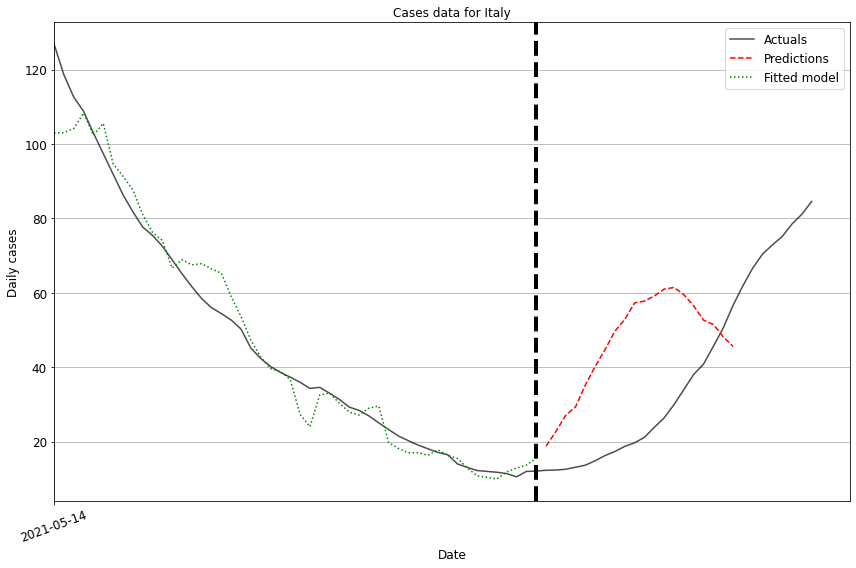

In [121]:
# Make "short prediction" after the discovery date
# delta here is the number of days after the discovery date for the target
# predicting the trend for 20 days
delta = 92
rscModel =syn_model(target, singVals, [data_df.iloc[delta:]], train_length + 20, train_length, otherStates=donors)
rscModel.fit_model(filter_donor = False, filter_method = 'percentile', singVals_estimate = True, singval_mathod ='auto')

predictions = rscModel.predictions
model_fit = rscModel.model_fit

fig, axes = plt.subplots(1, 1, figsize = (12, 8))

rscModel.plot(figure=fig, axes=axes, title_text="Cases data", ylimit=[], xlimit=[], logy=False, show_donors=False, tick_spacing=tick_spacing, xaxis="Date", yaxis="Daily cases", intervention_date_x_ticks=None, fontsize = 12)
#plt.savefig("../Figures/COVID/"+county_state+".png",bbox_inches='tight')    
plt.tight_layout()

print(rscModel.donors, rscModel.kSingularValues)

plt.show()

## HBO

outliers: ['Sweden' 'Portugal' 'Korea, South' 'Netherlands']
['France', 'Ireland', 'Germany', 'Denmark', 'Belgium', 'Sweden', 'Switzerland', 'Portugal', 'Norway', 'United Kingdom', 'Finland', 'Korea, South', 'Japan', 'Netherlands', 'Luxembourg', 'Austria', 'Slovenia', 'Russia', 'US', 'Spain', 'Czechia', 'Poland', 'Turkey'] 5


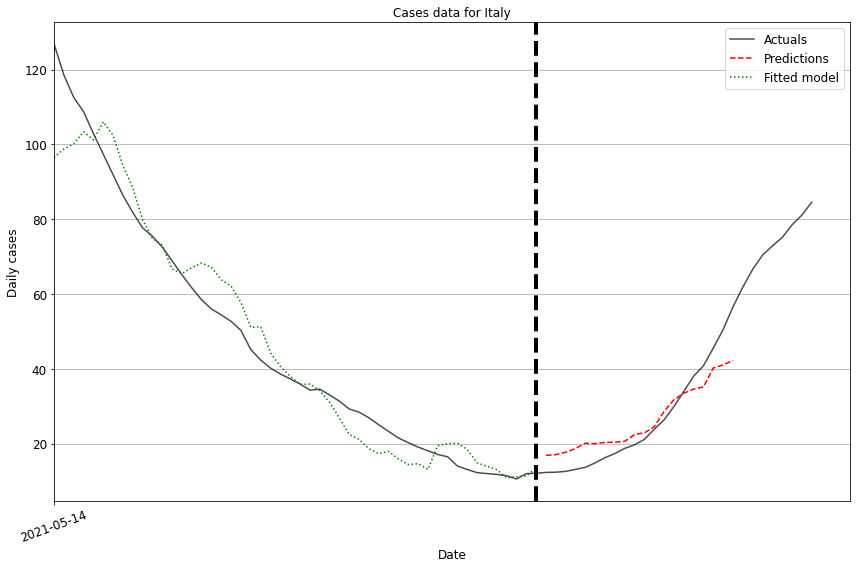

In [122]:

perm_dict = rscModel.permutation_distribution(show_graph = False, include_self = False, ri_method = 'ratio')
train_perm_dict = permutation_train_test(rscModel)
train_values = np.array(list(perm_dict.values()))

test_perm_dict = permutation_train_test(rscModel, train_err = False)
test_values = np.array(list(perm_dict.values()))

all_donors = np.array(list(perm_dict.keys()))
values = np.array(list(perm_dict.values()))

input_df =  pd.DataFrame([train_values,test_values]).transpose() # pd.DataFrame(values)
hbos = HBOS(alpha=0.1, contamination=0.15, n_bins=20, tol=0.5)
hbos.fit(input_df)
output = hbos.decision_function(input_df)
res = hbos.predict(input_df)
res = np.array(res, dtype = bool)

print('outliers:', all_donors[res])
# for item in all_donors[res]:
#     if item in outliers:
#         TP+=1
#     else:
#         FP+=1

################################################
################################################

rscModel2 =syn_model(target, singVals, [data_df.iloc[delta:]], train_length + 20, train_length, otherStates=list(all_donors[~res]))
try:
    rscModel2.fit_model(filter_donor = False, singVals_estimate = True, singval_mathod ='auto')
except Exception as e: 
    print(e)

fig, axes = plt.subplots(1, 1, figsize = (12, 8))

rscModel2.plot(figure=fig, axes=axes, title_text="Cases data", ylimit=[], xlimit=[], logy=False, show_donors=False, tick_spacing=tick_spacing, xaxis="Date", yaxis="Daily cases", intervention_date_x_ticks=None, fontsize = 12)
#plt.savefig("../Figures/COVID/"+county_state+".png",bbox_inches='tight')    
plt.tight_layout()

print(rscModel.donors, rscModel.kSingularValues)

plt.show()

### Backward



target: Italy
donors: 23 removed: ['Netherlands']
training error before: 34.896844472420064 training error after: 47.68431274301737


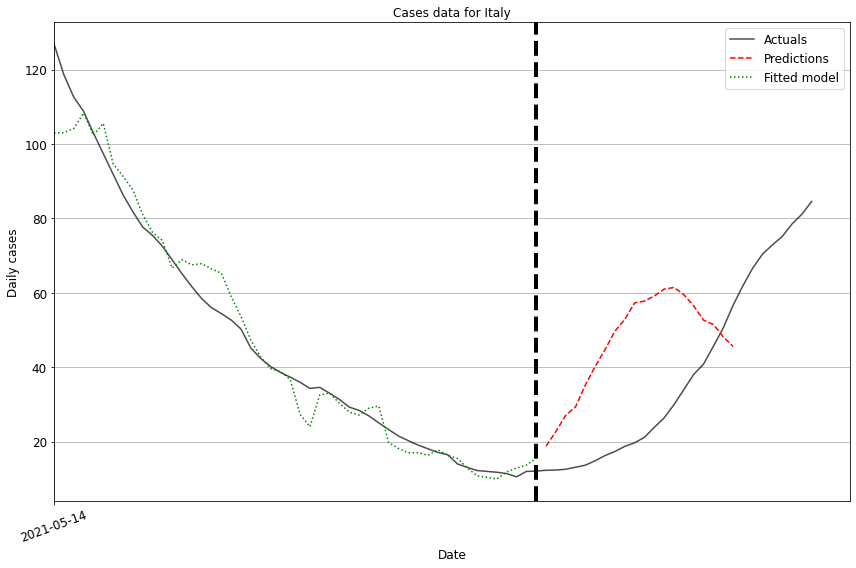

In [123]:
rscModel1 = rscModel
final_donors = rscModel1.donors
print('\n\ntarget:', target)
while len(final_donors)>3:
    #rscModel =syn_model(state, singVals, [df], high_thresh, low_thresh, otherStates=otherStates)
    #rscModel.fit_model(filter_donor = False, singVals_estimate = True, singval_mathod ='auto')
    #train_err1 = rscModel.train_err
    new_donors = backward_donor_elimination(rscModel1, metric=mean_squared_error, output = 'training_error')

    '''
    print(new_donors)
    rscModel1 =syn_model(state, singVals, [df], high_thresh, low_thresh, otherStates=final_donors)
    rscModel1.fit_model(filter_donor = False, singVals_estimate = True, singval_mathod ='auto')
    '''
    rscModel2 =syn_model(target, singVals, [data_df.iloc[delta:]], train_length + 20, train_length, otherStates=list(new_donors))
    #temp_model=syn_model(rscModel.state, rscModel.kSingularValues, rscModel.dfs, high_thresh, low_thresh, 
    #                    random_distribution = rscModel.random_distribution, lambdas = rscModel.lambdas, mRSC = rscModel.mRSC, otherStates=donorPool)

    rscModel2.fit_model(filter_donor = False, singVals_estimate = True, singval_mathod ='auto')

    print('training error before:', rscModel1.train_err,'training error after:', rscModel2.train_err)
    if rscModel1.train_err <= rscModel2.train_err:
        break
    final_donors = new_donors
    rscModel1 = rscModel2
    
fig, axes = plt.subplots(1, 1, figsize = (12, 8))

rscModel1.plot(figure=fig, axes=axes, title_text="Cases data", ylimit=[], xlimit=[], logy=False, show_donors=False, tick_spacing=tick_spacing, xaxis="Date", yaxis="Daily cases", intervention_date_x_ticks=None, fontsize = 12)
#plt.savefig("../Figures/COVID/"+county_state+".png",bbox_inches='tight')    
plt.tight_layout()


plt.show()

### Other analysis with the US counties

In [87]:
#plt.rcParams['figure.figsize'] = (24.0, 9.0)


lambdas = 1
high_thresh = 120
low_thresh = 30

model = syn_model(target, 7, [df], high_thresh, low_thresh, otherStates = group) #Create a syn_model object
model.fit_model(filter_donor = False, filter_method = 'iqr', ri_method = "diff", filter_metrics = mean_error)
print("Donors # %s"%(len(model.donors)))
print("Model train err %2.4f, Model test err %2.4f"%(model.train_err, model.test_err))


Donors # 6
Model train err 0.2316, Model test err 578.1750


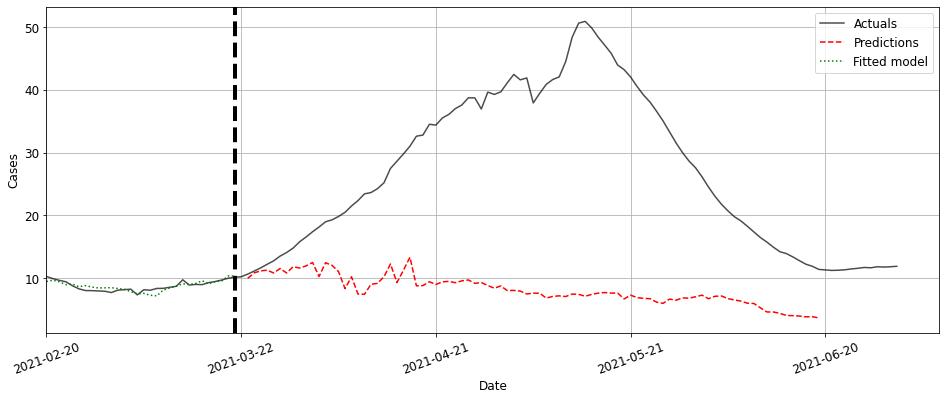

In [88]:
model.plot()

In [90]:
donor_states = ['Connecticut',
 'Maine',
 'Massachusetts',
 'New Hampshire',
 'Rhode Island',
 'Vermont',
 'New Jersey',
 'New York'
]

donors = []
for counties in uscounties_cases.columns:
    names = counties.split('-')
    if names[-1] in donor_states and names[0] != 'Unknown':
        donors.append(counties)


In [157]:
df = all_cases_data_pop_daily
target = 'Japan'

singVals = 9

donor_start = "2021-03-01"
target_start = "2021-04-01"
prediction_length = 50
train_length = 50

donor_start_idx = list(df.index).index(donor_start) - train_length
donor_end_idx =  list(df.index).index(donor_start) + prediction_length

target_start_idx = list(df.index).index(target_start) - train_length
target_end_idx = list(df.index).index(target_start) + prediction_length

target_df = df[target][target_start_idx:target_end_idx]
donor_df = df[donors][donor_start_idx:donor_end_idx]
donor_df.index = target_df.index

df = pd.concat([target_df, donor_df], axis = 1)

#df = df[donors][donor_start_idx:donor_end_idx]



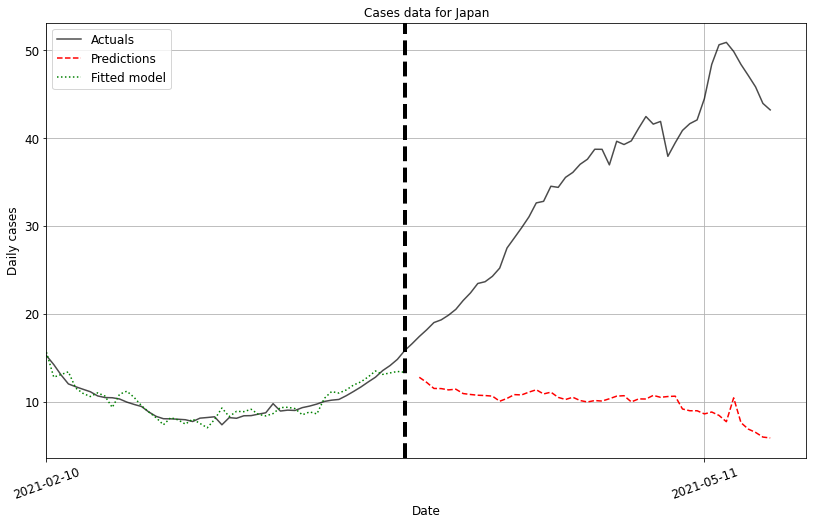

In [159]:
rscModel =syn_model(target, singVals, [df], train_length + prediction_length, train_length, otherStates=donors)
rscModel.fit_model(filter_donor = True, filter_method = 'percentile', singVals_estimate = False, singval_mathod ='auto')

predictions = rscModel.predictions
model_fit = rscModel.model_fit

fig, axes = plt.subplots(1, 1, figsize = (12, 8))

rscModel.plot(figure=fig, axes=axes, title_text="Cases data", ylimit=[], xlimit=[], logy=False, show_donors=False, tick_spacing=tick_spacing, xaxis="Date", yaxis="Daily cases", intervention_date_x_ticks=None, fontsize = 12)
#plt.savefig("../Figures/COVID/"+county_state+".png",bbox_inches='tight')    
plt.tight_layout()


plt.show()

In [139]:
print('donors = ',rscModel.donors, 'singvals:', rscModel.kSingularValues)
    

donors =  ['Addison-Vermont', 'Allegany-New York', 'Atlantic-New Jersey', 'Belknap-New Hampshire', 'Bennington-Vermont', 'Bristol-Massachusetts', 'Bristol-Rhode Island', 'Broome-New York', 'Burlington-New Jersey', 'Cape May-New Jersey', 'Carroll-New Hampshire', 'Cattaraugus-New York', 'Cayuga-New York', 'Chautauqua-New York', 'Chemung-New York', 'Chenango-New York', 'Cheshire-New Hampshire', 'Chittenden-Vermont', 'Clinton-New York', 'Columbia-New York', 'Cortland-New York', 'Cumberland-Maine', 'Cumberland-New Jersey', 'Delaware-New York', 'Dutchess-New York', 'Essex-Massachusetts', 'Essex-New Jersey', 'Essex-New York', 'Essex-Vermont', 'Fairfield-Connecticut', 'Franklin-Maine', 'Franklin-Massachusetts', 'Franklin-New York', 'Franklin-Vermont', 'Fulton-New York', 'Genesee-New York', 'Gloucester-New Jersey', 'Grafton-New Hampshire', 'Grand Isle-Vermont', 'Greene-New York', 'Hamilton-New York', 'Hampden-Massachusetts', 'Hancock-Maine', 'Hartford-Connecticut', 'Herkimer-New York', 'Hillsbo

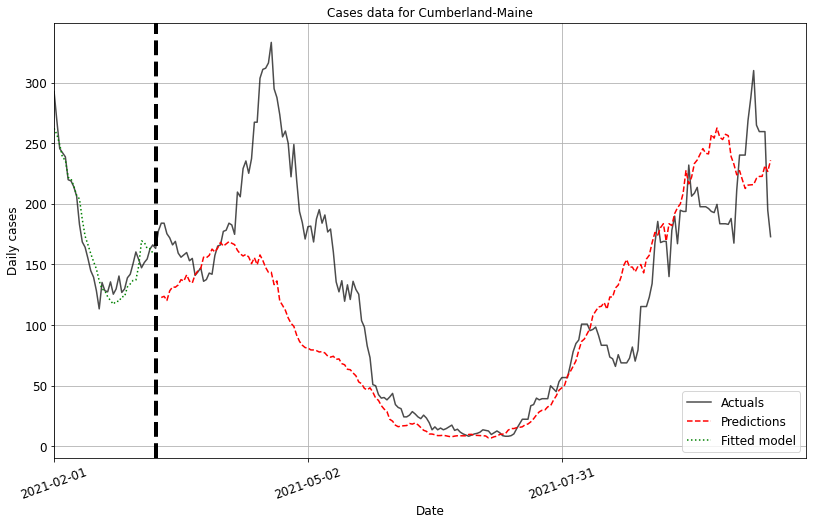

donors =  ['Addison-Vermont', 'Allegany-New York', 'Barnstable-Massachusetts', 'Bennington-Vermont', 'Carroll-New Hampshire', 'Cattaraugus-New York', 'Chenango-New York', 'Cheshire-New Hampshire', 'Chittenden-Vermont', 'Clinton-New York', 'Columbia-New York', 'Delaware-New York', 'Essex-New York', 'Essex-Vermont', 'Franklin-Maine', 'Franklin-Massachusetts', 'Franklin-New York', 'Franklin-Vermont', 'Fulton-New York', 'Grafton-New Hampshire', 'Greene-New York', 'Hamilton-New York', 'Hampshire-Massachusetts', 'Hunterdon-New Jersey', 'Litchfield-Connecticut', 'Livingston-New York', 'Madison-New York', 'Merrimack-New Hampshire', 'Middlesex-Connecticut', 'Newport-Rhode Island', 'Ontario-New York', 'Orleans-New York', 'Orleans-Vermont', 'Otsego-New York', 'Oxford-Maine', 'Rensselaer-New York', 'Rockingham-New Hampshire', 'Rutland-Vermont', 'Saratoga-New York', 'Schoharie-New York', 'Schuyler-New York', 'Seneca-New York', 'St. Lawrence-New York', 'Strafford-New Hampshire', 'Sullivan-New York',

In [95]:
#df = df[df.columns[(df>100).any()]].copy()
start_date = '2021-02-01'
low_thresh_date = '2021-03-10'
df = all_cases_data_pop_daily.loc[start_date:]
df_pop = all_cases_data_pop.loc[start_date:]
high_thresh = df_pop.shape[0]
low_thresh = (pd.to_datetime(low_thresh_date) - pd.to_datetime(start_date)).days

plt.rcParams.update({'font.size': 30})
tick_spacing=90
#FONTSIZE = 28
#sizes = df.applynortheastries.last_valid_index)
#sizes = sizes.fillna(0).astype(int)
singVals=4
trainDF=df.iloc[:low_thresh,:]
testDF=df.iloc[low_thresh+1:high_thresh,:]

#num_rows_to_plot = int(len(targets))+1
#plt.rcParams['figure.figsize'] = (24, num_rows_to_plot*5.0)
plt.rcParams['figure.figsize'] = (26, 8.0)

i=1
for state in ['Cumberland-Maine']:
#otherStates = donors.copy()
    ''''''
    try:
        otherStates = df_pop.columns[(df_pop.iloc[low_thresh] < 
                                      df_pop[state].iloc[low_thresh]+.5*df_pop[state].iloc[low_thresh])&(df_pop.iloc[low_thresh]
                                      > df_pop[state].iloc[low_thresh]-0.5*df_pop[state].iloc[low_thresh])]
    except:
        continue
    otherStates = list(otherStates[otherStates.isin(donors)])

    
    
    if state in otherStates:
        otherStates.remove(state)
        
    
    # Adding outliers:
    for item in ['Jefferson-Alabama','Madison-Alabama','Mobile-Alabama', 'Harris-Texas', 'Dallas-Texas', 'Tarrant-Texas']:
        otherStates.append(item)
    
    rscModel =syn_model(state, singVals, [df], high_thresh, low_thresh, otherStates=otherStates)
    rscModel.fit_model(filter_donor = True, filter_method = 'quantile', singVals_estimate = True, singval_mathod ='auto')
    
    predictions = rscModel.predictions
    model_fit = rscModel.model_fit
     
    fig, axes = plt.subplots(1, 1, figsize = (12, 8))

    rscModel.plot(figure=fig, axes=axes, title_text="Cases data", ylimit=[], xlimit=[], logy=False, show_donors=False, tick_spacing=tick_spacing, xaxis="Date", yaxis="Daily cases", intervention_date_x_ticks=None, fontsize = 12)
    #plt.savefig("../Figures/COVID/"+county_state+".png",bbox_inches='tight')    
    plt.tight_layout()
    

    plt.show()

    print('donors = ',rscModel.donors, 'singvals:', rscModel.kSingularValues)
    